# 이미지캡션 하려면 tensorflow==2.1.0 버전 써야함

In [1]:
#!pip install keras==2.3.1
#모델가져올 때
#!pip install tensorflow==2.1.0

In [2]:
import keras
import glob
from PIL import Image
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import pickle
from tqdm import tqdm
import pandas as pd
from keras.preprocessing import sequence
from keras.models import Sequential
from keras.layers import LSTM, Embedding, add, Input, Dropout, TimeDistributed, Dense, RepeatVector,Activation, Flatten,Concatenate
from keras.optimizers import Adam, RMSprop
from keras.layers.wrappers import Bidirectional
from keras.applications.inception_v3 import InceptionV3
from keras.preprocessing import image
import nltk

Using TensorFlow backend.


In [3]:
token = 'Flickr8k_text/food.txt'

In [4]:
#문자의 공백을 없애주는 역할 - strip은 양쪽 끝만 되게 때문에 split("\n")를 통해 중간의 공백도 채워줌
captions = open(token, 'r', encoding='UTF8').read().strip().split('\n')

In [5]:
len(captions)

2655

## 이미지캡셔닝 사전 만들기

In [6]:
token = 'Flickr8k_text/food.txt'
captions = open(token, 'r', encoding='UTF8').read().strip().split('\n')
#아래 작업 자체가 이미지와 문장의 딕셔너리를 생성하고 있는 작업
d = {}
for i, row in enumerate(captions):
    row = row.split('\t')
    row[0] = row[0][:len(row[0])-2]
    if row[0] in d:
        d[row[0]].append(row[1])
    else:
        d[row[0]] = [row[1]]

In [7]:
len(d)

532

In [8]:
images = 'Flickr8k_Dataset/data\\'

In [9]:
len(images)

22

In [10]:
# 조건에 맞게 모든 파일을 jpg 형식으로 변환
img = glob.glob(images+'*.jpg')

In [11]:
len(img)

531

In [12]:
#train 이미지 파일 텍스트로 저장된 장소
train_images_file = 'Flickr8k_text/train.txt'

In [13]:
train_images = set(open(train_images_file, 'r', encoding='UTF8').read().strip().split('\n'))

In [14]:
def split_data(l):
    temp = []
# img라는 경로에서 하나씩 빼왔을 때 
    for i in img:
# train 데이터 이름이 동일하다면 불러옴
# i[len(images):] ->'Flickr8k_Dataset/data\\1.jpg 중에서 뒤에 1.jpg 부분
# 그 경로 가져와서 Flickr8k_Dataset/data\\1.jpg이 경로를 저장
        if i[len(images):] in l:
            temp.append(i)
    return temp

In [15]:
#경로를 찾아서 이미지 열게 도와주는 함수
train_img = split_data(train_images)
len(train_img)

473

In [16]:
train_img

['Flickr8k_Dataset/data\\1.jpg',
 'Flickr8k_Dataset/data\\10.jpg',
 'Flickr8k_Dataset/data\\100.jpg',
 'Flickr8k_Dataset/data\\101.jpg',
 'Flickr8k_Dataset/data\\102.jpg',
 'Flickr8k_Dataset/data\\103.jpg',
 'Flickr8k_Dataset/data\\104.jpg',
 'Flickr8k_Dataset/data\\105.jpg',
 'Flickr8k_Dataset/data\\106.jpg',
 'Flickr8k_Dataset/data\\107.jpg',
 'Flickr8k_Dataset/data\\108.jpg',
 'Flickr8k_Dataset/data\\109.jpg',
 'Flickr8k_Dataset/data\\11.jpg',
 'Flickr8k_Dataset/data\\110.jpg',
 'Flickr8k_Dataset/data\\111.jpg',
 'Flickr8k_Dataset/data\\112.jpg',
 'Flickr8k_Dataset/data\\113.jpg',
 'Flickr8k_Dataset/data\\114.jpg',
 'Flickr8k_Dataset/data\\115.jpg',
 'Flickr8k_Dataset/data\\116.jpg',
 'Flickr8k_Dataset/data\\117.jpg',
 'Flickr8k_Dataset/data\\118.jpg',
 'Flickr8k_Dataset/data\\119.jpg',
 'Flickr8k_Dataset/data\\12.jpg',
 'Flickr8k_Dataset/data\\120.jpg',
 'Flickr8k_Dataset/data\\121.jpg',
 'Flickr8k_Dataset/data\\122.jpg',
 'Flickr8k_Dataset/data\\123.jpg',
 'Flickr8k_Dataset/data\\

In [17]:
#경로를 찾아서 이미지 열게 도와주는 함수
val_images_file = 'Flickr8k_text/Flickr_8k.devImages.txt'
val_images = set(open(val_images_file, 'r').read().strip().split('\n'))

In [18]:
val_img = split_data(val_images)
len(val_img)

0

In [19]:
#경로를 찾아서 이미지 열게 도와주는 함수
test_images_file = 'Flickr8k_text/test.txt'
test_images = set(open(test_images_file, 'r', encoding='UTF8').read().strip().split('\n'))

In [20]:
test_img = split_data(test_images)
len(test_img)

31

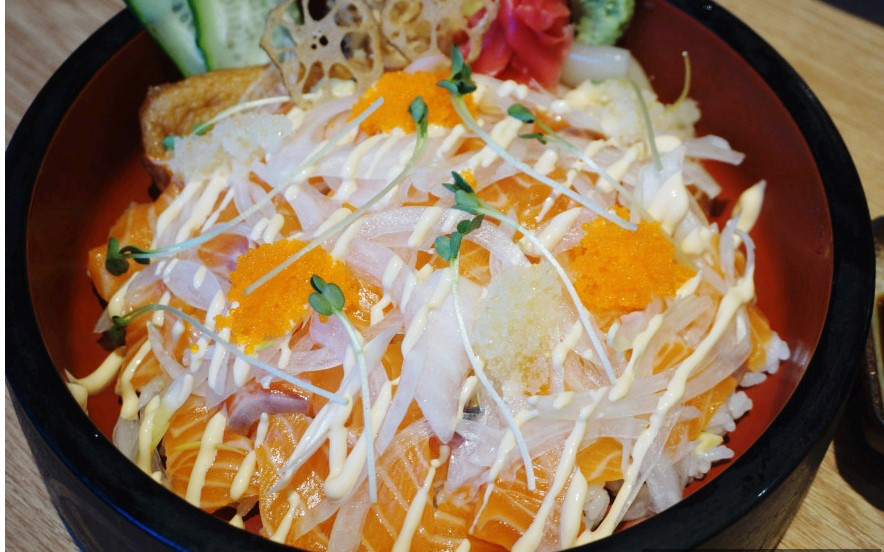

In [21]:
Image.open(train_img[2])

We will feed these images to VGG-16 to get the encoded images. Hence we need to preprocess the images as the authors of VGG-16 did. The last layer of VGG-16 is the softmax classifier(FC layer with 1000 hidden neurons) which returns the probability of a class. This layer should be removed so as to get a feature representation of an image. We will use the last Dense layer(4096 hidden neurons) after popping the classifier layer. Hence the shape of the encoded image will be (1, 4096)

In [22]:
#픽셀을 정규화 해주는 함수
def preprocess_input(x):
    x /= 255.
    x -= 0.5
    x *= 2.
    return x

In [23]:
#픽셀 규격을 299,299로 맞춰줌
def preprocess(image_path):
    img = image.load_img(image_path, target_size=(299, 299))
    x = image.img_to_array(img)
    x = np.expand_dims(x, axis=0)

    x = preprocess_input(x)
    return x

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


findfont: Font family ['normal'] not found. Falling back to DejaVu Sans.


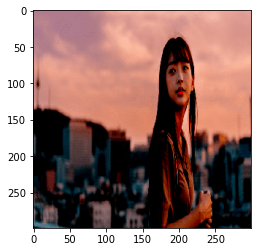

In [24]:
plt.imshow(np.squeeze(preprocess('./images/girl.jpg')))

In [25]:
#모델 가져오기
model = InceptionV3(weights='imagenet')

In [26]:
from keras.models import Model

new_input = model.input
#마지막 층은 사용하지 않기 때문에 -2를 빼주고 나머지 모델층을 사용함
hidden_layer = model.layers[-2].output

model_new = Model(new_input, hidden_layer)

In [27]:
tryi = model_new.predict(preprocess('./images/girl.jpg'))

In [28]:
tryi.shape

(1, 2048)

In [29]:
def encode(image):
    #사이즈 조정하는 함수
    image = preprocess(image)
    temp_enc = model_new.predict(image)
    temp_enc = np.reshape(temp_enc, temp_enc.shape[1])
    return temp_enc

In [30]:
name = 'tata'
sample =  name + '.jpg'
encode(sample)

FileNotFoundError: [Errno 2] No such file or directory: 'tata.jpg'

In [ ]:
encoding_train = {}
#tqdm 진행률을 알려주는 함수
for img in tqdm(train_img):
    #사이즈 조정되어 펼쳐진 이미지를 경로를 encoding_train 딕셔너리에 넣어주는 작업
    #이미지 자체를 여기에 넣어준다고 생각하면됨
    encoding_train[img[len(images):]] = encode(img)

In [ ]:
with open("encoded_images_inceptionV3.p", "wb") as encoded_pickle:
    pickle.dump(encoding_train, encoded_pickle)

In [31]:
encoding_train = pickle.load(open('encoded_images_inceptionV3.p', 'rb'))

In [32]:
encoding_train['2.jpg'].shape

(2048,)

In [33]:
encoding_test = {}
for img in tqdm(test_img):
    encoding_test[img[len(images):]] = encode(img)

100%|██████████| 31/31 [00:01<00:00, 28.39it/s]


In [34]:
with open("encoded_images_test_inceptionV3.p", "wb") as encoded_pickle:
    pickle.dump(encoding_test, encoded_pickle) 

In [35]:
# pickle.load -> 텍스트형태 이외의 리스트나 클래스 같은 형태를 가져올 때 사용
encoding_test = pickle.load(open('encoded_images_test_inceptionV3.p', 'rb'))

In [36]:
encoding_test[test_img[0][len(images):]].shape

(2048,)

In [37]:
train_img[0]

'Flickr8k_Dataset/data\\1.jpg'

In [38]:
train_img[len(images):]

['Flickr8k_Dataset/data\\119.jpg',
 'Flickr8k_Dataset/data\\12.jpg',
 'Flickr8k_Dataset/data\\120.jpg',
 'Flickr8k_Dataset/data\\121.jpg',
 'Flickr8k_Dataset/data\\122.jpg',
 'Flickr8k_Dataset/data\\123.jpg',
 'Flickr8k_Dataset/data\\124.jpg',
 'Flickr8k_Dataset/data\\125.jpg',
 'Flickr8k_Dataset/data\\126.jpg',
 'Flickr8k_Dataset/data\\127.jpg',
 'Flickr8k_Dataset/data\\128.jpg',
 'Flickr8k_Dataset/data\\129.jpg',
 'Flickr8k_Dataset/data\\13.jpg',
 'Flickr8k_Dataset/data\\130.jpg',
 'Flickr8k_Dataset/data\\131.jpg',
 'Flickr8k_Dataset/data\\132.jpg',
 'Flickr8k_Dataset/data\\133.jpg',
 'Flickr8k_Dataset/data\\134.jpg',
 'Flickr8k_Dataset/data\\135.jpg',
 'Flickr8k_Dataset/data\\136.jpg',
 'Flickr8k_Dataset/data\\137.jpg',
 'Flickr8k_Dataset/data\\138.jpg',
 'Flickr8k_Dataset/data\\139.jpg',
 'Flickr8k_Dataset/data\\14.jpg',
 'Flickr8k_Dataset/data\\140.jpg',
 'Flickr8k_Dataset/data\\141.jpg',
 'Flickr8k_Dataset/data\\142.jpg',
 'Flickr8k_Dataset/data\\143.jpg',
 'Flickr8k_Dataset/data

In [39]:
train_img[3][len(images):]

'101.jpg'

In [40]:
train_d = {}
#이미지의 텍스트 부분만 추출하여 저장하는 반복문
for i in train_img:
    if i[len(images):] in d:
        train_d[i] = d[i[len(images):]]

In [41]:
with open("text.p", "wb") as encoded_pickle:
    pickle.dump(train_d, encoded_pickle)

In [42]:
train_d = pickle.load(open('text.p', 'rb'))

In [43]:
len(train_d)

473

In [44]:
# images ->'Flickr8k_Dataset/Flicker8k_Dataset/' 경로 지칭
train_d[images+'2.jpg']

['This is a spicy seacheon bath containing white clams and abalone.',
 'It seems that the octopus is alive in the seacheontang.',
 'It is a seacheon bath full of scallops.',
 'While looking for spicy food, I found a Haecheontang restaurant.',
 'It is a mixture of two abalone and several seafood.']

In [45]:
val_d = {}
#이미지의 텍스트 부분만 추출하여 저장하는 반복문
for i in val_img:
    if i[len(images):] in d:
        val_d[i] = d[i[len(images):]]

In [46]:
len(val_d)

0

In [47]:
test_d = {}
#이미지의 텍스트 부분만 추출하여 저장하는 반복문
for i in test_img:
    if i[len(images):] in d:
        test_d[i] = d[i[len(images):]]

In [48]:
len(test_d)

31

매핑

In [184]:
caps = []
for key, val in train_d.items():
    for i in val:
        caps.append('<start> ' + i + ' <end>')

In [185]:
words = [i.split() for i in caps]

In [186]:
unique = pickle.load(open('unique.p', 'rb'))

In [187]:
unique = []
for i in words:
    unique.extend(i)

In [188]:
#list(set()) -> 중복단어 제거 후 정렬하여 나타내줌
unique = list(set(unique))

In [189]:
with open("word.p", "wb") as encoded_pickle:
    pickle.dump(unique, encoded_pickle)

In [190]:
unique = pickle.load(open('word.p', 'rb'))

In [191]:
len(unique)

3010

In [192]:
unique

['jajangdak',
 'winter.',
 'figure',
 "mother's",
 'semolina',
 'exotic',
 'salted',
 'How',
 'enough',
 'Skateboard',
 'Dad',
 'forks',
 'game,',
 'Sapgyeopsal',
 'left.',
 'sunlight.',
 'komakjeon',
 'Finely',
 'field.',
 'owner',
 'cheeseburger',
 'sincerity.',
 'precious',
 'it,',
 'seasoned.',
 'twisting',
 'soak',
 'friend.',
 'surfing,',
 'away',
 'ssamjang.',
 'gives',
 'wants',
 'Lots',
 'salad',
 'portable',
 'Kumpir',
 'wooden',
 'Dakgalbi.',
 'foods.',
 'stop',
 'Pickled',
 'Tteokbokki,',
 'salivary',
 'Vegetarians',
 'made',
 'Tteokgalbi,',
 'It’s',
 'Also',
 'gathered.',
 'aroma',
 'mistake.',
 'stew.',
 'Jamaican-style',
 'popular.',
 'slice',
 'top.',
 'tteokbokki.',
 'stands',
 'especially',
 'jambalaya.',
 'Bacon',
 'plan',
 'engraved',
 'best',
 'from',
 'House',
 'insufficient',
 'barbecue.',
 'our',
 'mixed.',
 'Sushi',
 'serve',
 'Almond',
 'circulation.',
 'waiting',
 'could',
 'bad,',
 'puts',
 'Itaewon,',
 'patty',
 'he',
 'All',
 'cute.',
 'why',
 'contrast.',

단어를 매핑하는 작업

In [153]:
word2idx = {val:index for index, val in enumerate(unique)}

In [154]:
word2idx['food']

99

In [155]:
idx2word = {index:val for index, val in enumerate(unique)}

In [156]:
idx2word[1000]

'food,'

가장 긴 단어의 길이

In [157]:
max_len = 0
for c in caps:
    c = c.split()
    if len(c) > max_len:
        max_len = len(c)
max_len

26

In [158]:
len(unique), max_len

(3010, 26)

In [159]:
vocab_size = len(unique)

In [160]:
vocab_size

3010

Adding <start> and <end> to all the captions to indicate the starting and ending of a sentence. This will be used while we predict the caption of an image

In [161]:
# w 모드로 열었기 때문에 파일이 있으면 덮어쓰여지고 없으면 파일을 생성해줌
f = open('flickr8k_training_dataset.txt', 'w', encoding='UTF8')
# "image_id\tcaptions\n"를 써줌
f.write("image_id\tcaptions\n")

18

In [162]:
for key, val in train_d.items():
    for i in val:
        f.write(key[len(images):] + "\t" + "<start> " + i +" <end>" + "\n")
#f.close() -> 생략해도 되지만 다시 쓰려고 하면 오류 날 수 있기 때문에 해주는 게 좋음
f.close()

In [163]:
df = pd.read_csv('flickr8k_training_dataset.txt', delimiter='\t')

In [164]:
len(df)

2364

In [165]:
df

,image_id,captions
0,1.jpg,"<start> Mussels and clams, and octopus and sea..."
1,1.jpg,<start> It is a must-eat food in Donghae. <end>
2,1.jpg,"<start> On a rainy day, I went to eat Haecheon..."
3,1.jpg,<start> The big octopus looks good. <end>
4,10.jpg,<start> It is a spicy soup with scallops and a...
...,...,...
2359,99.jpg,<start> It is decorated with lotus root and te...
2360,99.jpg,<start> It is a simple sushi covered with salm...
2361,99.jpg,<start> Sushi that is easier to eat than rice ...
2362,99.jpg,<start> It is a special sashimi sushi that is ...


In [166]:
c = [i for i in df['captions']]
len(c)

2364

In [167]:
imgs = [i for i in df['image_id']]

In [168]:
a = c[-1]
a, imgs[-1]

("<start> A lot of sashimi and tempura are covered so that you can't see the rice. <end>",
 '99.jpg')

In [169]:
for i in a.split():
    print (i, "=>", word2idx[i])

<start> => 869
A => 2276
lot => 724
of => 729
sashimi => 254
and => 429
tempura => 1326
are => 1459
covered => 1947
so => 220
that => 3004
you => 1584
can't => 1683
see => 2016
the => 975
rice. => 2019
<end> => 622


In [170]:
samples_per_epoch = 0
for ca in caps:
    samples_per_epoch += len(ca.split())-1

In [171]:
samples_per_epoch

25395

## Generator 

We will use the encoding of an image and use a start word to predict the next word.
After that, we will again use the same image and use the predicted word 
to predict the next word.
So, the image will be used at every iteration for the entire caption. 
This is how we will generate the caption for an image. Hence, we need to create 
a custom generator for that.

The CS231n lecture by Andrej Karpathy explains this concept very clearly and beautifully.
Link for the lecture:- https://youtu.be/cO0a0QYmFm8?t=32m25s

In [172]:
def data_generator(batch_size = 32):
        partial_caps = []
        next_words = []
        images = []
        
        df = pd.read_csv('flickr8k_training_dataset.txt', delimiter='\t')
        df = df.sample(frac=1)
        iter = df.iterrows()
        c = []
        imgs = []
        for i in range(df.shape[0]):
            x = next(iter)
            c.append(x[1][1])
            imgs.append(x[1][0])


        count = 0
        while True:
            for j, text in enumerate(c):
                current_image = encoding_train[imgs[j]]
                for i in range(len(text.split())-1):
                    count+=1
                    
                    partial = [word2idx[txt] for txt in text.split()[:i+1]]
                    partial_caps.append(partial)
                    
                    # Initializing with zeros to create a one-hot encoding matrix
                    # This is what we have to predict
                    # Hence initializing it with vocab_size length
                    n = np.zeros(vocab_size)
                    # Setting the next word to 1 in the one-hot encoded matrix
                    n[word2idx[text.split()[i+1]]] = 1
                    next_words.append(n)
                    
                    images.append(current_image)

                    if count>=batch_size:
                        next_words = np.asarray(next_words)
                        images = np.asarray(images)
                        partial_caps = sequence.pad_sequences(partial_caps, maxlen=max_len, padding='post')
                        yield [[images, partial_caps], next_words]
                        partial_caps = []
                        next_words = []
                        images = []
                        count = 0    

## 모델 생성

## 첫번째 모델

In [173]:
embedding_size = 300
# 이미지 특성 추출 부분
inputs1 = Input(shape=(2048,))
fe1 = Dropout(0.5)(inputs1)
fe2 = Dense(embedding_size, activation='relu')(fe1)
fe3 = RepeatVector(max_len)(fe2)

# 텍스트 특성 추출 부분
inputs2 = Input(shape=(max_len,))
se1 = Embedding(vocab_size, embedding_size, mask_zero=True)(inputs2)
se2 = Dropout(0.5)(se1)
se3 = LSTM(256, return_sequences=True)(se2)
se4 = TimeDistributed(Dense(300))(se3)

# 두 모델 합쳐서 마지막에 출력
#vocab_size -> 텍스트의 총가지수 중에 하나 선택하는 것이므로
#마지막 출력층의 Dense에 적용
decoder1 = add([fe3, se4])
decoder2 = Bidirectional(LSTM(256, return_sequences=False))(decoder1)
outputs = Dense(vocab_size, activation='softmax')(decoder2)

# merge the two input models
final_model = Model(inputs=[inputs1, inputs2], outputs=outputs)
final_model.compile(loss='categorical_crossentropy', optimizer=RMSprop(), metrics=['accuracy'])

final_model.summary()

Model: "model_4"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_7 (InputLayer)            (None, 26)           0                                            
__________________________________________________________________________________________________
input_6 (InputLayer)            (None, 2048)         0                                            
__________________________________________________________________________________________________
embedding_3 (Embedding)         (None, 26, 300)      903000      input_7[0][0]                    
__________________________________________________________________________________________________
dropout_5 (Dropout)             (None, 2048)         0           input_6[0][0]                    
____________________________________________________________________________________________

## 두번째 모델

In [174]:
# embedding_size = 300
# # 이미지 특성 추출 부분
# inputs1 = Input(shape=(2048,))
# fe1 = Dropout(0.5)(inputs1)
# fe2 = Dense(256, activation='relu')(fe1)

# # 텍스트 특성 추출 부분
# inputs2 = Input(shape=(max_len,))
# se1 = Embedding(vocab_size, embedding_size, mask_zero=True)(inputs2)
# se2 = Dropout(0.5)(se1)
# se3 = LSTM(256)(se2)

# # 두 모델 합쳐서 마지막에 출력
# #vocab_size -> 텍스트의 총가지수 중에 하나 선택하는 것이므로
# #마지막 출력층의 Dense에 적용
# decoder1 = add([fe2, se3])
# decoder2 = Dense(256, activation='relu')(decoder1)
# outputs = Dense(vocab_size, activation='softmax')(decoder2)

# # merge the two input models
# final_model2 = Model(inputs=[inputs1, inputs2], outputs=outputs)
# final_model2.compile(loss='categorical_crossentropy', optimizer=RMSprop(), metrics=['accuracy'])

# final_model2.summary()

In [175]:
import os
# 학습 결과를 저장할 디렉토리 생성
checkpoint_dir = os.getcwd() + "/model"
os.makedirs(checkpoint_dir, exist_ok=True)

In [176]:
print(checkpoint_dir)

C:\Users\smhrd\3차프로젝트\ImageCaptioning(캡셔닝)\Image-Captioning-master/model


# 학습하기

In [177]:
from keras.callbacks import EarlyStopping, ModelCheckpoint
#과대 적합을 방지하기 위한 조기 종료 설정
early_stop = EarlyStopping(monitor = 'loss', verbose = 1, patience= 7)

# 최적의 학습 결과를 저장하기 위한 ModelCheckpoint 설정
# min의 의미는 손실값이 최소화될 때마다 저장하게 만듦
checkpoint = ModelCheckpoint(filepath=checkpoint_dir+"/"+"weight.h5", monitor = "loss",
                            verbose=1, mode='min', save_best_only=True)

In [178]:
final_model.fit_generator(data_generator(batch_size=128), samples_per_epoch=2000, nb_epoch=300, 
                          callbacks = [early_stop, checkpoint])

C:\Users\smhrd\Anaconda3\envs\deep\lib\site-packages\ipykernel_launcher.py:2: UserWarning: The semantics of the Keras 2 argument `steps_per_epoch` is not the same as the Keras 1 argument `samples_per_epoch`. `steps_per_epoch` is the number of batches to draw from the generator at each epoch. Basically steps_per_epoch = samples_per_epoch/batch_size. Similarly `nb_val_samples`->`validation_steps` and `val_samples`->`steps` arguments have changed. Update your method calls accordingly.
  
C:\Users\smhrd\Anaconda3\envs\deep\lib\site-packages\ipykernel_launcher.py:2: UserWarning: Update your `fit_generator` call to the Keras 2 API: `fit_generator(<generator..., callbacks=[<keras.ca..., steps_per_epoch=2000, epochs=300)`
  
C:\Users\smhrd\Anaconda3\envs\deep\lib\site-packages\tensorflow_core\python\framework\indexed_slices.py:433: UserWarning: Converting sparse IndexedSlices to a dense Tensor of unknown shape. This may consume a large amount of memory.
  "Converting sparse IndexedSlices to a 

Epoch 1/300
2000/2000 [==============================] - 124s 62ms/step - loss: 4.1555 - accuracy: 0.2652

Epoch 00001: loss improved from inf to 4.15554, saving model to C:\Users\smhrd\3차프로젝트\ImageCaptioning(캡셔닝)\Image-Captioning-master/model/weight.h5
Epoch 2/300
2000/2000 [==============================] - 122s 61ms/step - loss: 2.2941 - accuracy: 0.4866

Epoch 00002: loss improved from 4.15554 to 2.29405, saving model to C:\Users\smhrd\3차프로젝트\ImageCaptioning(캡셔닝)\Image-Captioning-master/model/weight.h5
Epoch 3/300
2000/2000 [==============================] - 122s 61ms/step - loss: 1.3108 - accuracy: 0.6947 ETA: 2 - ETA: 22s - loss: 1.3764 - ac - ETA: 21s - loss: 1.37 - ETA: 20s - loss: 1.3701 - accurac - ETA: 17s - loss: 1.3600 - ac - ETA: 16s - l

Epoch 00003: loss improved from 2.29405 to 1.31081, saving model to C:\Users\smhrd\3차프로젝트\ImageCaptioning(캡셔닝)\Image-Captioning-master/model/weight.h5
Epoch 4/300
2000/2000 [==============================] - 123s 62ms/step - loss: 0.7403

KeyboardInterrupt: 

In [ ]:
# from keras.callbacks import EarlyStopping, ModelCheckpoint
# #과대 적합을 방지하기 위한 조기 종료 설정
# early_stop = EarlyStopping(monitor = 'loss', verbose = 1, patience= 3)

# # 최적의 학습 결과를 저장하기 위한 ModelCheckpoint 설정
# # min의 의미는 손실값이 최소화될 때마다 저장하게 만듦
# checkpoint = ModelCheckpoint(filepath=checkpoint_dir+"/"+"weight2.h5", monitor = "loss",
#                             verbose=1, mode='min', save_best_only=True)

In [ ]:
# final_model2.fit_generator(data_generator(batch_size=128), samples_per_epoch=2000, nb_epoch=100, 
#                           callbacks = [early_stop, checkpoint])

## 예측

In [179]:
# 첫번째 모델 불러오기

import os
from tensorflow.keras.models import load_model

# 학습된 이미지 저장 경로 설정
checkpoint_dir = os.getcwd() + '/model/'

# 학습된 모델 불러오기
final_model = load_model(checkpoint_dir + 'weight.h5')

# 결과 확인하기
print(final_model.summary())

Model: "model_4"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_7 (InputLayer)            [(None, 26)]         0                                            
__________________________________________________________________________________________________
input_6 (InputLayer)            [(None, 2048)]       0                                            
__________________________________________________________________________________________________
embedding_3 (Embedding)         (None, 26, 300)      903000      input_7[0][0]                    
__________________________________________________________________________________________________
dropout_5 (Dropout)             (None, 2048)         0           input_6[0][0]                    
____________________________________________________________________________________________

In [ ]:
# # 두번째 모델 불러오기

# import os
# from tensorflow.keras.models import load_model

# # 학습된 이미지 저장 경로 설정
# checkpoint_dir = os.getcwd() + '/model/'

# # 학습된 모델 불러오기
# final_model = load_model(checkpoint_dir + 'weight2.h5')

# # 결과 확인하기
# print(final_model.summary())

In [205]:
def predict_captions(image):
    start_word = ["<start>"]
    while True:
        par_caps = [word2idx[i] for i in start_word]
        par_caps = sequence.pad_sequences([par_caps], maxlen=max_len, padding='post')
        e = encoding_test[image[len(images):]]
        preds = final_model.predict([np.array([e]), np.array(par_caps)])
        word_pred = idx2word[np.argmax(preds[0])]
        start_word.append(word_pred)
        
        if word_pred == "<end>" or len(start_word) > max_len:
            break
            
    return ' '.join(start_word[1:-1])

In [206]:
def beam_search_predictions(image, beam_index = 3):
    start = [word2idx["<start>"]]
    
    start_word = [[start, 0.0]]
    
    while len(start_word[0][0]) < max_len:
        temp = []
        for s in start_word:
            par_caps = sequence.pad_sequences([s[0]], maxlen=max_len, padding='post')
            e = encoding_test[image[len(images):]]
            preds = final_model.predict([np.array([e]), np.array(par_caps)])
            
            word_preds = np.argsort(preds[0])[-beam_index:]
            
            # Getting the top <beam_index>(n) predictions and creating a 
            # new list so as to put them via the model again
            for w in word_preds:
                next_cap, prob = s[0][:], s[1]
                next_cap.append(w)
                prob += preds[0][w]
                temp.append([next_cap, prob])
                    
        start_word = temp
        # Sorting according to the probabilities
        start_word = sorted(start_word, reverse=False, key=lambda l: l[1])
        # Getting the top words
        start_word = start_word[-beam_index:]
    
    start_word = start_word[-1][0]
    intermediate_caption = [idx2word[i] for i in start_word]

    final_caption = []
    
    for i in intermediate_caption:
        if i != '<end>':
            final_caption.append(i)
        else:
            break
    
    final_caption = ' '.join(final_caption[1:])
    return final_caption

# 이미지 음악으로 변환

When eating a rocket burger, take out one pinch and be delicious.


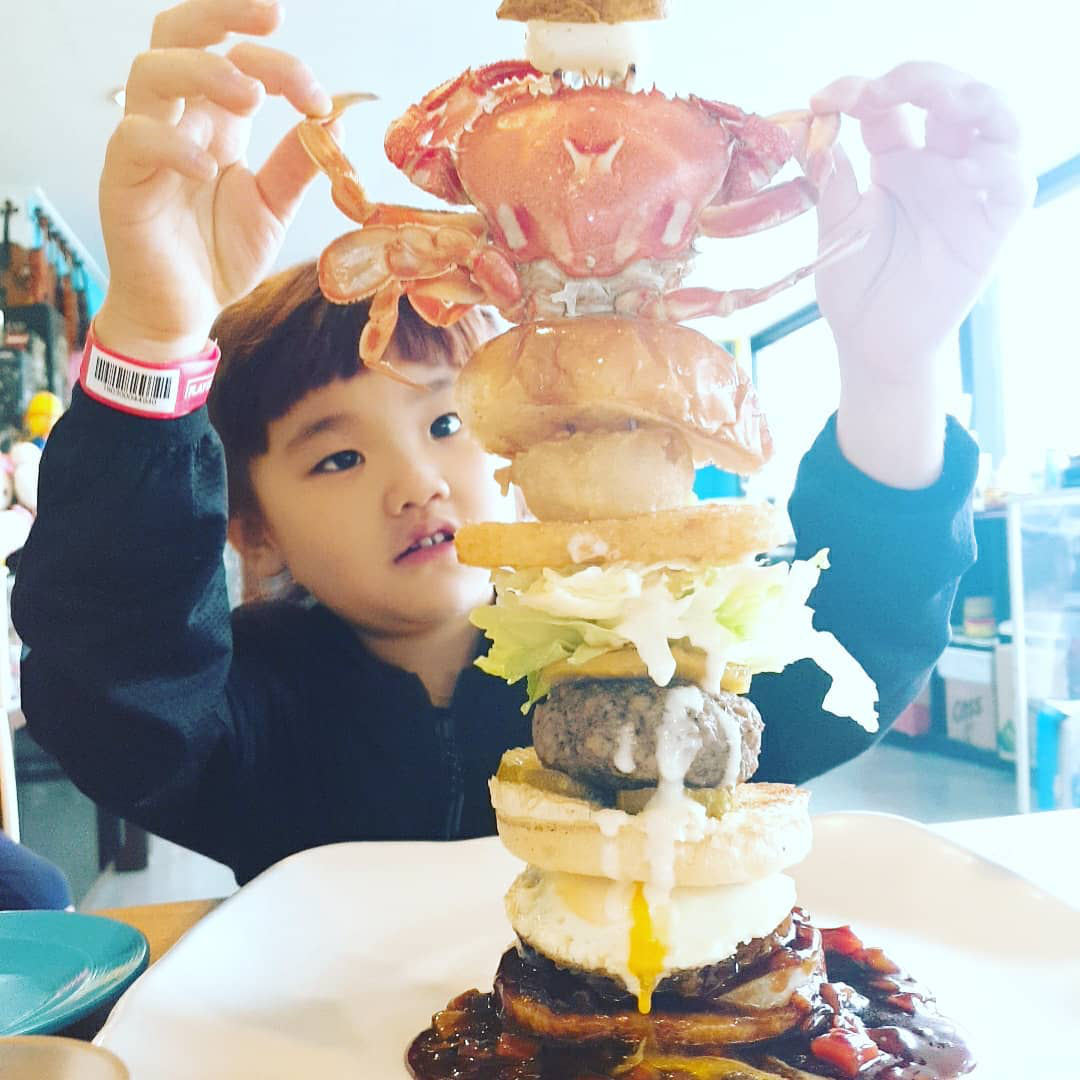

In [218]:
#이미지 랜덤 생성
im = test_img[int(np.random.randint(0, 31, size=1))]
print(str(predict_captions(im)))

Image.open(im)

In [183]:
song =[[('g#3', 16.0), ('e4', 16.0), ('d#4', 16.0), ('d4', 16.0), 
        ('d#4', 16.0), ('r', 16.0), ('c#4', 16.0), ('b3', 16.0), 
        ('a#3', 16.0), ('r', 16.0), ('g#3', 16.0), ('g3', 16.0), 
        ('g#3', 16.0), ('r', 16.0), ('d#3', 16.0), ('e3', 16.0), 
        ('d#3', 16.0), ('e3', 16.0), ('d#3', 16.0), ('d3', 16.0), 
        ('d#3', 16.0), ('g3', 16.0), ('b3', 16.0), ('a#3', 16.0), 
        ('g#3', 16.0), ('r', 16.0), ('g#3', 16.0), ('a#3', 16.0), 
        ('b3', 16.0), ('r', 16.0), ('a#3', 16.0), ('b3', 16.0), 
        ('c#4', 16.0), ('r', 16.0), ('b3', 16.0), ('a#3', 16.0), 
        ('g3', 16.0), ('r', 16.0), ('g3', 16.0), ('a#3', 16.0), 
        ('b3', 16.0), ('r', 16.0), ('a#3', 16.0), ('g#3', 16.0), 
        ('d#3', 16.0), ('r', 16.0), ('d#3', 16.0), ('e3', 16.0), 
        ('d#3', 16.0), ('e3', 16.0), ('d#3', 16.0), ('d3', 16.0), 
        ('d#3', 16.0), ('g3', 16.0), ('b3', 16.0), ('a#3', 16.0), 
        ('g#3', 16.0), ('r', 16.0), ('g#3', 16.0), ('g3', 16.0), 
        ('g#3', 16.0), ('r', 16.0), ('g#4', 16.0)],
       [('g5', 2.0), ('d5', 1.3333333333333333), ('e5', 8.0), ('f5', 8.0), 
        ('g5', 4.0), ('e5', 8.0), ('d5', 8.0), ('e5', 5.333333333333333), 
        ('c5', 5.314878892780648), ('e5', 5.314878892710022), ('d5', 1.0), 
        ('a#4', 4.0), ('d5', 4.0), ('e5', 4.0), ('f5', 4.0), ('c5', 1.0), 
        ('g4', 2.0), ('a4', 0.4999999999999998), ('a5', 2.0), 
        ('e5', 1.3333333333333333), ('c5', 8.0), ('e5', 8.0), ('d5', 4.0), 
        ('a#4', 8.0), ('g4', 8.0), ('a5', 2.0), ('e5', 1.3333333333333333), 
        ('c5', 8.0), ('e5', 8.0), ('d5', 4.0), ('a#4', 8.0), ('g4', 8.0), 
        ('g5', 2.0), ('d5', 1.3333333333333333), ('a#4', 8.0), ('d5', 8.0), 
        ('c5', 4.0), ('a4', 8.0), ('g4', 8.0), ('a4', 4.0), ('e4', 8.0), 
        ('a4', 8.0), ('f4', 4.0), ('d4', 8.0), ('f4', 8.0), ('d4', 2.0), 
        ('c4', 2.000000000000007), ('c6', 2.0), ('g5', 1.3333333333333333), 
        ('a5', 8.0), ('a#5', 8.0), ('c6', 4.0), ('a5', 8.0), ('g5', 8.0), 
        ('a5', 5.333333333333333), ('f5', 5.314878892498194), 
        ('a5', 5.314878892498194), ('g5', 1.0), ('d#5', 4.0), ('g5', 4.0), 
        ('a5', 4.0), ('a#5', 4.0), ('f5', 1.0), ('a5', 4.0), ('a#5', 4.0), 
        ('c6', 4.0), ('d6', 4.0), ('a5', 1.0), ('a#5', 4.0), ('d6', 4.0), 
        ('f6', 2.0), ('c#6', 2.0000000003000054), ('r', 8.084210527894808), 
        ('d5', 8.0), ('e5', 8.0), ('r', 4.0), ('f5', 8.0), ('a5', 8.0), 
        ('f6', 2.0), ('c#6', 2.0), ('r', 4.0), ('d5', 8.0), ('e5', 8.0), 
        ('r', 4.0), ('f5', 8.0), ('a5', 8.0), ('f5', 4.0), ('d4', 8.0), 
        ('e4', 8.0), ('f5', 0.3333333333333333), ('f4', 8.0), ('a4', 8.0), 
        ('f4', 2.0), ('f4', 1.0), ('d4', 4.0), ('c4', 4.0), ('d4', 1.0), 
        ('c5', 4.0), ('a#4', 8.0), ('a4', 8.0), ('g4', 1.3333333333333333), 
        ('a4', 8.0), ('a#4', 8.0), ('c5', 4.0), ('c5', 8.0), ('d#5', 8.0), 
        ('d5', 0.5), ('c5', 4.0), ('a#4', 8.0), ('a4', 8.0), 
        ('g4', 1.3333333333333333), ('a4', 8.0), ('a#4', 8.0), ('c5', 8.0), 
        ('d#5', 8.0), ('e5', 0.6666666666666666), ('d#5', 4.0), ('e5', 4.0), 
        ('g5', 4.0), ('f5', 8.0), ('e5', 8.0), ('d5', 2.0), ('d5', 2.0), 
        ('e5', 4.0), ('c5', 0.08888888888888886), ('f5', 4.0), ('e5', 8.0), 
        ('d5', 8.0), ('c5', 1.0), ('d5', 4.0), ('f5', 0.5), ('e5', 4.0), 
        ('d5', 8.0), ('c5', 8.0), ('a#4', 2.0), ('a#5', 2.0), ('a5', 4.0), 
        ('g5', 4.0), ('e5', 0.4444444444444444), ('f5', 0.6666666666666666), 
        ('f4', 4.0), ('f5', 0.23529411764705882), ('e4', 4.0), ('f4', 16.0), 
        ('a4', 16.0), ('f4', 16.0), ('e4', 4.0), ('d4', 4.0), ('c4', 2.0), 
        ('e4', 4.0), ('c#4', 4.0), ('c#4', 4.0), ('e4', 4.0), ('f#4', 4.0), 
        ('g#4', 4.0), ('e4', 2.0), ('f#5', 4.0), ('g#5', 4.0), ('e5', 4.0), 
        ('c#6', 4.0), ('f#5', 4.0), ('g#5', 16.0), ('f#5', 16.0), ('g#5', 16.0),
        ('e5', 4.0), ('b4', 4.0), ('g#4', 4.0), ('b4', 4.0), ('g#4', 4.0), 
        ('e4', 4.0), ('f#4', 2.0), ('c#5', 2.0), ('f#5', 4.0), ('g#5', 4.0), 
        ('e5', 4.0), ('c#6', 4.0), ('f#5', 4.0), ('g#5', 16.0), ('f#5', 16.0), 
        ('g#5', 16.0), ('e5', 4.0), ('b5', 4.0), ('c#6', 4.0), ('e6', 4.0), 
        ('d#6', 4.0), ('b5', 4.0), ('c#6', 4.0), ('e6', 4.0), ('f#6', 4.0), 
        ('b5', 4.000000000000114), ('c#6', 4.0), ('e6', 4.0), ('d#6', 4.0), 
        ('b5', 4.0), ('c#6', 4.0), ('e6', 4.0), ('f#6', 4.0), ('b5', 4.0), 
        ('g6', 1.3333333333333333), ('a5', 4.0), ('g5', 2.6666666666666665), 
        ('a4', 8.0), ('g4', 2.6666666666666665), ('a4', 8.0), ('d4', 4.0), 
        ('e4', 4.0), ('c4', 4.0), ('a4', 4.0), ('d4', 4.0), ('e4', 16.0), 
        ('d4', 16.0), ('e4', 16.0), ('c4', 2.0), ('d5', 4.0), ('e5', 16.0), 
        ('d5', 16.0), ('e5', 16.0), ('c5', 2.0), ('g5', 2.0), 
        ('d5', 1.3333333333333333), ('e5', 8.0), ('f5', 8.0), ('g5', 4.0), 
        ('e5', 8.0), ('d5', 8.0), ('e5', 5.333333333333333), 
        ('c5', 5.31487889037946), ('e5', 5.31487889037946), ('d5', 1.0), 
        ('a#4', 4.0), ('d5', 4.0), ('e5', 4.0), ('f5', 4.0), ('c5', 1.0), 
        ('g4', 2.0), ('a4', 0.5), ('a5', 2.0), ('e5', 1.3333333333333333), 
        ('c5', 8.0), ('e5', 8.0), ('d5', 4.0), ('a#4', 8.0), ('g4', 8.0), 
        ('a5', 2.0), ('e5', 1.3333333333333333), ('c5', 8.0), ('e5', 8.0), 
        ('d5', 4.0), ('a#4', 8.0), ('g4', 8.0), ('g5', 2.0), 
        ('d5', 1.3333333333333333), ('a#4', 8.0), ('d5', 8.0), ('c5', 4.0), 
        ('a4', 8.0), ('f4', 8.0), ('g5', 2.0), ('d5', 1.3333333333333333), 
        ('a#4', 8.0), ('d5', 8.0), ('c5', 4.0), ('d5', 4.0), ('a#4', 4.0), 
        ('e4', 0.02580385041830461), ('a4', 4.0), ('a4', 2.0), ('a#4', 4.0), 
        ('a4', 4.0), ('a4', 2.0), ('a#4', 4.0), ('a#4', 0.6666666666666666), 
        ('a4', 4.0), ('a#4', 16.0), ('d5', 16.0), ('a#4', 16.0), ('a4', 4.0), 
        ('g4', 4.0), ('f4', 2.0), ('a#5', 4.0), ('a4', 0.49983729252717796), 
        ('a5', 4.0), ('a5', 2.0), ('a#5', 4.0), ('a#5', 2.0), ('a5', 2.0), 
        ('a#5', 4.0), ('a5', 4.0), ('a#5', 16.0), ('d6', 16.0), ('a#5', 16.0), 
        ('a5', 2.0), ('g5', 2.0), ('a5', 0.36355029584697357), ('a6', 1.0)],
       [('d3', 16.0), ('r', 16.0), ('g3', 16.0), ('r', 16.0), ('a3', 16.0), 
        ('r', 16.0), ('d3', 16.0), ('r', 16.0), ('g3', 16.0), ('r', 16.0), 
        ('a3', 16.0), ('r', 16.0), ('d3', 16.0), ('r', 16.0), ('d4', 16.0), 
        ('r', 16.0), ('b3', 16.0), ('r', 16.0), ('d3', 16.0), ('r', 16.0), 
        ('a3', 16.0), ('r', 16.0), ('g3', 16.0), ('r', 16.0), ('d3', 16.0), 
        ('r', 16.0), ('a3', 16.0), ('r', 16.0), ('g3', 16.0), ('r', 16.0), 
        ('d3', 16.0), ('r', 16.0), ('r', 5.333333333333333), ('f#3', 16.0), 
        ('g3', 16.0), ('r', 16.0), ('d3', 16.0), ('r', 16.0), ('g3', 16.0), 
        ('r', 16.0), ('a3', 16.0), ('r', 16.0), ('d3', 16.0), ('r', 8.0), 
        ('f#3', 16.0), ('r', 16.0), ('f#3', 16.0), ('g3', 16.0), ('r', 16.0), 
        ('a3', 16.0), ('r', 16.0), ('d3', 16.0), ('r', 16.0), ('b3', 16.0), 
        ('r', 16.0), ('a3', 16.0), ('r', 16.0), ('g3', 16.0), ('r', 16.0), 
        ('d3', 16.0), ('r', 16.0), ('f#3', 16.0), ('r', 16.0), ('g3', 16.0), 
        ('r', 16.0), ('e3', 16.0), ('r', 16.0), ('g3', 16.0), ('r', 16.0), 
        ('d4', 16.0), ('r', 16.0), ('f#3', 16.0), ('r', 16.0), ('g3', 16.0),
        ('r', 16.0), ('a3', 16.0), ('r', 16.0), ('f#3', 16.0), ('r', 16.0), 
        ('g3', 16.0), ('r', 16.0), ('f#3', 16.0), ('r', 16.0), ('a3', 16.0), 
        ('r', 16.0), ('g3', 16.0), ('r', 16.0), ('f#4', 16.0), ('r', 16.0), 
        ('g4', 16.0), ('r', 16.0), ('g3', 16.0), ('r', 16.0), ('b3', 16.0), 
        ('r', 16.0), ('d4', 16.0)],
      [('g#3', 16.0), ('e4', 16.0), ('d#4', 16.0), ('d4', 16.0), 
         ('d#4', 16.0), ('r', 16.0), ('c#4', 16.0), ('b3', 16.0), 
         ('a#3', 16.0), ('r', 16.0), ('g#3', 16.0), ('g3', 16.0), 
         ('g#3', 16.0), ('r', 16.0), ('d#3', 16.0), ('e3', 16.0), 
         ('d#3', 16.0), ('e3', 16.0), ('d#3', 16.0), ('d3', 16.0), 
         ('d#3', 16.0), ('g3', 16.0), ('b3', 16.0), ('a#3', 16.0), 
         ('g#3', 16.0), ('r', 16.0), ('g#3', 16.0), ('a#3', 16.0), 
         ('b3', 16.0), ('r', 16.0), ('a#3', 16.0), ('b3', 16.0), 
         ('c#4', 16.0), ('r', 16.0), ('b3', 16.0), ('a#3', 16.0), 
         ('g3', 16.0), ('r', 16.0), ('g3', 16.0), ('a#3', 16.0), 
         ('b3', 16.0), ('r', 16.0), ('a#3', 16.0), ('g#3', 16.0), 
         ('d#3', 16.0), ('r', 16.0), ('d#3', 16.0), ('e3', 16.0), 
         ('d#3', 16.0), ('e3', 16.0), ('d#3', 16.0), ('d3', 16.0), 
         ('d#3', 16.0), ('g3', 16.0), ('b3', 16.0), ('a#3', 16.0), 
         ('g#3', 16.0), ('r', 16.0), ('g#3', 16.0), ('g3', 16.0), 
         ('g#3', 16.0), ('r', 16.0), ('g#4', 16.0)],
      ['c4', 4], ['c4', 4], ['c4', 4], ['d4', 8], ['e4', 4], ['e4', 4], 
         ['d4', 8], ['e4', 4], ['f4', 8], ['g4', 2], ['c4', 8], ['c4', 8], 
         ['c4', 8], ['g4', 8], ['g4', 8], ['g4', 8], ['e4', 8], ['e4', 8], 
         ['e4', 8], ['c4', 8], ['c4', 8], ['c4', 8], ['g4', 4], ['f4', 8], 
         ['e4', 4], ['d4', 8], ['c4', 2]]

In [ ]:
# 리스트 형태로 음표 따오기
import pysynth as ps
from pyknon.genmidi import Midi
from pyknon.music import NoteSeq, Note, Rest
from src.MarkovMusic import MusicMatrix
from pprint import pprint
import random

#이미지 랜덤 생성
im = test_img[int(np.random.randint(0, 31, size=1))]
print(str(predict_captions(im)))

alphabets = {'a': 0,'b': 0,'c': 0,'d': 0,'e': 0,'f': 0,'g': 0,'h': 0,'i': 0,'j': 0,'k': 0,
             'l': 0, 'm': 0,'n': 0,'o': 0, 'p': 0, 'q': 0, 'r': 0, 's': 0, 't': 0, 'u': 0,
             'v': 0, 'w': 0, 'x': 0, 'y': 0, 'z': 0}

for ch in s:
    if 97 <= ord(ch) <= 122:
        alphabets[ch] += 1
code = sorted(alphabets.items(), key=operator.itemgetter(1),reverse=True)

code_list = []
#코드 갯수 늘리기 range범위
for i in range(8):
    code_list.append(code[i][0])

code_num = []
for i in code_list:
    if("a" == i or "m" == i or "y" == i):
        code_num.append(0)
    elif("b" == i or "n" == i):
        code_num.append(1)
    elif("c" == i or "o" == i or "z" == i):
        code_num.append(2)
    elif("d" == i or "p" == i):
        code_num.append(3)
    elif("e" == i or "q" == i):
        code_num.append(4)
    elif("f" == i or "r" == i):
        code_num.append(5)
    elif("g" == i or "s" == i):
        code_num.append(6)
    elif("h" == i or "t" == i):
        code_num.append(7)
    elif("i" == i or "u" == i):
        code_num.append(8)
    elif("j" == i or "v" == i):
        code_num.append(9)
    elif("k" == i or "w" == i):
        code_num.append(10)
    elif("l" == i or "x" == i):
        code_num.append(11)

# 위의 리스트 중 하나 가져 오기
matrix = MusicMatrix(random.choice(song))

song[0][0] = ('d4',2)

start_note = ['d4', 16]

random_song = []
for i in range(0, 100):
    start_note = matrix.next_note(start_note)
    random_song.append(start_note)

# ps.make_wav(random_song, fn='examples/random_undertail.wav')
pprint(random_song)
make_midi(midi_path='midi/random_undertail.mid', notes=random_song)

#### 기존 예제

In [ ]:
im = test_img[8]
print ('Normal Max search:', predict_captions(im))
print ('Beam Search, k=3:', beam_search_predictions(im, beam_index=3))
print ('Beam Search, k=5:', beam_search_predictions(im, beam_index=5))
print ('Beam Search, k=7:', beam_search_predictions(im, beam_index=7))
Image.open(im)

# 플라스크 연동을 위한 작업

In [1]:
import keras
import glob
from PIL import Image
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import pickle
from tqdm import tqdm
import pandas as pd
from keras.preprocessing import sequence
from keras.models import Sequential
from keras.layers import LSTM, Embedding, add, Input, Dropout, TimeDistributed, Dense, RepeatVector,Activation, Flatten,Concatenate
from keras.optimizers import Adam, RMSprop
from keras.layers.wrappers import Bidirectional
from keras.applications.inception_v3 import InceptionV3
from keras.preprocessing import image
import nltk

Using TensorFlow backend.


In [2]:
#함수 모아 놓기

# 세 함수는 이미지 사이즈 조정
def preprocess_input(x):
    x /= 255.
    x -= 0.5
    x *= 2.
    return x
def preprocess(image_path):
    img = image.load_img(image_path, target_size=(299, 299))
    x = image.img_to_array(img)
    x = np.expand_dims(x, axis=0)
    x = preprocess_input(x)
    return x
def encode(image):
    image = preprocess(image)
    temp_enc = model_new.predict(image)
    temp_enc = np.reshape(temp_enc, temp_enc.shape[1])
    return temp_enc

#generator
def data_generator(batch_size = 32):
        partial_caps = []
        next_words = []
        images = []
        
        df = pd.read_csv('flickr8k_training_dataset.txt', delimiter='\t')
        df = df.sample(frac=1)
        iter = df.iterrows()
        c = []
        imgs = []
        for i in range(df.shape[0]):
            x = next(iter)
            c.append(x[1][1])
            imgs.append(x[1][0])


        count = 0
        while True:
            for j, text in enumerate(c):
                current_image = encoding_train[imgs[j]]
                for i in range(len(text.split())-1):
                    count+=1
                    
                    partial = [word2idx[txt] for txt in text.split()[:i+1]]
                    partial_caps.append(partial)
                    
                    # Initializing with zeros to create a one-hot encoding matrix
                    # This is what we have to predict
                    # Hence initializing it with vocab_size length
                    n = np.zeros(vocab_size)
                    # Setting the next word to 1 in the one-hot encoded matrix
                    n[word2idx[text.split()[i+1]]] = 1
                    next_words.append(n)
                    
                    images.append(current_image)

                    if count>=batch_size:
                        next_words = np.asarray(next_words)
                        images = np.asarray(images)
                        partial_caps = sequence.pad_sequences(partial_caps, maxlen=max_len, padding='post')
                        yield [[images, partial_caps], next_words]
                        partial_caps = []
                        next_words = []
                        images = []
                        count = 0    

# 예측하기
def predict_captions(image):
    start_word = ["<start>"]
    while True:
        par_caps = [word2idx[i] for i in start_word]
        par_caps = sequence.pad_sequences([par_caps], maxlen=max_len, padding='post')
        e = store[sample[:]]
        preds = final_model.predict([np.array([e]), np.array(par_caps)])
        word_pred = idx2word[np.argmax(preds[0])]
        start_word.append(word_pred)
        
        if word_pred == "<end>" or len(start_word) > max_len:
            break
            
    return ' '.join(start_word[1:-1])

In [3]:
#데이터 전처리
name = '91'
sample =  name + '.jpg'
store = {}

preprocess(sample)

#모델 가져오기
model = InceptionV3(weights='imagenet')

from keras.models import Model

new_input = model.input
#마지막 층은 사용하지 않기 때문에 -2를 빼주고 나머지 모델층을 사용함
hidden_layer = model.layers[-2].output

model_new = Model(new_input, hidden_layer)



store[sample[:]] = encode(sample)

with open("music.p", "wb") as encoded_pickle:
    pickle.dump(sample, encoded_pickle)
encoding = pickle.load(open('music.p', 'rb'))
store[name+".jpg"].shape

train_d = pickle.load(open('text.p', 'rb'))

caps = []
for key, val in train_d.items():
    for i in val:
        caps.append('<start> ' + i + ' <end>')

words = [i.split() for i in caps]
unique = pickle.load(open('word.p', 'rb'))

max_len = 0
for c in caps:
    c = c.split()
    if len(c) > max_len:
        max_len = len(c)

word2idx = {val:index for index, val in enumerate(unique)}
idx2word = {index:val for index, val in enumerate(unique)}
vocab_size = len(unique)

samples_per_epoch = 0
for ca in caps:
    samples_per_epoch += len(ca.split())-1

In [4]:
# 모델 적용
embedding_size = 300
# 이미지 특성 추출 부분
inputs1 = Input(shape=(2048,))
fe1 = Dropout(0.5)(inputs1)
fe2 = Dense(embedding_size, activation='relu')(fe1)
fe3 = RepeatVector(max_len)(fe2)

# 텍스트 특성 추출 부분
inputs2 = Input(shape=(max_len,))
se1 = Embedding(vocab_size, embedding_size, mask_zero=True)(inputs2)
se2 = Dropout(0.5)(se1)
se3 = LSTM(256, return_sequences=True)(se2)
se4 = TimeDistributed(Dense(300))(se3)

# 두 모델 합쳐서 마지막에 출력
#vocab_size -> 텍스트의 총가지수 중에 하나 선택하는 것이므로
#마지막 출력층의 Dense에 적용
decoder1 = add([fe3, se4])
decoder2 = Bidirectional(LSTM(256, return_sequences=False))(decoder1)
outputs = Dense(vocab_size, activation='softmax')(decoder2)

# merge the two input models
final_model = Model(inputs=[inputs1, inputs2], outputs=outputs)
final_model.compile(loss='categorical_crossentropy', optimizer=RMSprop(), metrics=['accuracy'])

final_model.summary()

Model: "model_2"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_3 (InputLayer)            (None, 26)           0                                            
__________________________________________________________________________________________________
input_2 (InputLayer)            (None, 2048)         0                                            
__________________________________________________________________________________________________
embedding_1 (Embedding)         (None, 26, 300)      903000      input_3[0][0]                    
__________________________________________________________________________________________________
dropout_1 (Dropout)             (None, 2048)         0           input_2[0][0]                    
____________________________________________________________________________________________

In [5]:
#모델 불러오기
import os
from tensorflow.keras.models import load_model

# 학습된 이미지 저장 경로 설정
checkpoint_dir = os.getcwd() + '/model/'

# 학습된 모델 불러오기
final_model = load_model(checkpoint_dir + 'weight.h5')

# 결과 확인하기
print(final_model.summary())

Model: "model_4"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_7 (InputLayer)            [(None, 26)]         0                                            
__________________________________________________________________________________________________
input_6 (InputLayer)            [(None, 2048)]       0                                            
__________________________________________________________________________________________________
embedding_3 (Embedding)         (None, 26, 300)      903000      input_7[0][0]                    
__________________________________________________________________________________________________
dropout_5 (Dropout)             (None, 2048)         0           input_6[0][0]                    
____________________________________________________________________________________________

Normal Max search: The sushi full of vegetables and red round flavor of the glass is made by half.


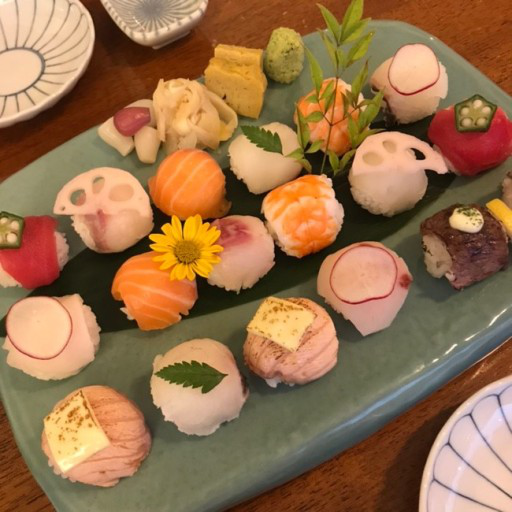

In [11]:
import pysynth as ps
from pyknon.genmidi import Midi
from pyknon.music import NoteSeq, Note, Rest
from src.MarkovMusic import MusicMatrix
from pprint import pprint
from pyknon.genmidi import Midi
from pyknon.music import NoteSeq, Note, Rest
import random
import itertools #2차원 리스트 1차원 해주기
import operator

print ('Normal Max search:', predict_captions(sample))
# 이미지를 숫자로 변환 로직
import operator
s = predict_captions(sample)
alphabets = {'a': 0,'b': 0,'c': 0,'d': 0,'e': 0,'f': 0,'g': 0,'h': 0,'i': 0,'j': 0,'k': 0,
             'l': 0, 'm': 0,'n': 0,'o': 0, 'p': 0, 'q': 0, 'r': 0, 's': 0, 't': 0, 'u': 0,
             'v': 0, 'w': 0, 'x': 0, 'y': 0, 'z': 0}

for ch in s:
    if 97 <= ord(ch) <= 122:
        alphabets[ch] += 1
code = sorted(alphabets.items(), key=operator.itemgetter(1),reverse=True)

code_list = []
#코드 갯수 늘리기 range범위
for i in range(8):
    code_list.append(code[i][0])

code_num = []
for i in code_list:
    if("a" == i or "m" == i or "y" == i):
        code_num.append(0)
    elif("b" == i or "n" == i):
        code_num.append(1)
    elif("c" == i or "o" == i or "z" == i):
        code_num.append(2)
    elif("d" == i or "p" == i):
        code_num.append(3)
    elif("e" == i or "q" == i):
        code_num.append(4)
    elif("f" == i or "r" == i):
        code_num.append(5)
    elif("g" == i or "s" == i):
        code_num.append(6)
    elif("h" == i or "t" == i):
        code_num.append(7)
    elif("i" == i or "u" == i):
        code_num.append(8)
    elif("j" == i or "v" == i):
        code_num.append(9)
    elif("k" == i or "w" == i):
        code_num.append(10)
    elif("l" == i or "x" == i):
        code_num.append(11)
        

# 랜덤 음악 생성 로직        
# pyknon이라는 라이브러리 깔려야함

     
def get_random_notes(n, pitches, durations, rests=True):
    if rests:
        #rests가 나오면 pitches에 r를 더해줌
        pitches.append('r')
        
    result = NoteSeq()

    for i in range(n):
        pitch = random.choice(pitches)
        duration = random.choice(durations)
        
        # 더해진 r이 있을 경우 조건에 부합하여 여기로 들어감
        if pitch == 'r':
            #듀레이션 만큼 음없이 넘어감
            result.append(Rest(dur=duration))
        #쉬는 부분 없을 경우
        else:
            #음표를 듀레이션 만큼 음으로 넘어감
            result.append(Note(pitch, octave=4, dur=duration))

    return result

# durations 음의 속도 조절 
notes1 = get_random_notes(30, pitches = code_num, durations = [1/8, 1/16])
notes2 = get_random_notes(30, pitches = code_num, durations = [1/4, 1/12])
midi = Midi(number_tracks=2, tempo=120)
midi.seq_notes(notes1, track=0)
midi.seq_notes(notes2, track=1)
# 저장 경로 examples
midi.write('midi/code.mid')
Image.open(sample)

In [7]:
import pysynth as ps
from pyknon.genmidi import Midi
from pyknon.music import NoteSeq, Note, Rest
from src.MarkovMusic import MusicMatrix
from pprint import pprint
from pyknon.genmidi import Midi
from pyknon.music import NoteSeq, Note, Rest
import random
import itertools #2차원 리스트 1차원 해주기
import operator

def make_midi(midi_path, notes, bpm=120):
    note_names = 'c c# d d# e f f# g g# a a# b'.split()

    result = NoteSeq()
    for n in notes:
        duration = 1. / n[1]

        if n[0].lower() == 'r':
            result.append(Rest(dur=duration))
        else:
            pitch = n[0][:-1]
            octave = int(n[0][-1]) + 1
            pitch_number = note_names.index(pitch.lower())
            
            result.append(Note(pitch_number, octave=octave, dur=duration))
            
    midi = Midi(number_tracks=1, tempo=bpm)
    midi.seq_notes(result, track=0)
    midi.write(midi_path)

In [8]:
song =  [[('d5', 4), ('b5', 4), ('a5', 4), ('b5', 4), ('d6', 4), ('a5', 2),
        ('d5', 8), ('d5', 8), ('e5', 4), ('g5', 8), ('g5', 2), ('e5', 8),
        ('d5', 2), ('g5', 6), ('a5', 6), ('b5', 4), ('a5', 6), ('b5', 6),
        ('e6', 6), ('d6', 2), ('a5', 8), ('b5', 4), ('b5', 8), ('b5', 8),
        ('c6', 4), ('b5', 4), ('a5', 4), ('g5', 4), ('b5', 4), ('a5', 2), ('d5', 4),
        ('b5', 6), ('a5', 6), ('b5', 6), ('d6', 6), ('a5', 4), ('d5', 8),
        ('d5', 8), ('e5', 6), ('g5', 8), ('g5', 4), ('e5', 8), ('d5', 4),
        ('g5', 6), ('a5', 8), ('b5', 8), ('a5', 6), ('b5', 8), ('e6', 8),
        ('d6', 4), ('d6', 8), ('d6', 8), ('a5', 8), ('b5', 4), ('b5', 8), ('b5', 8),
        ('c6', 8), ('b5', 8), ('a5', 4), ('g5', 8), ('g5', 4), ('d5', 8),
        ('e5', 8), ('g5', 8), ('d6', 2), ('c6', 8), ('b5', 8), ('a5', 6),
        ('a5', 8), ('g5', 8), ('f5', 8), ('g(', 4), ('e', 6),  ('g5', 6),
        ('d6', 4), ('e6', 8), ('d6', 4), ('c6', 8), ('b5', 4), ('a5', 8), ('b5', 4),
        ('g5', 8), ('g5', 8), ('e6', 4), ('g6', 8), ('f6', 4), ('e6', 8),
        ('c#6',8), ('d6', 2), ('e6', 8), ('f#6', 8), ('e6', 8), ('d6', 6),
        ('c6', 8), ('b5', 8), ('g5', 8), ('g5', 4), ('e5', 6), ('g5', 6),
        ('e6', 4), ('e6', 8), ('d#6', 8), ('g6', 8), ('f6', 2), ('b5', 8), ('b5', 6),
        ('g6', 6), ('f#6', 6), ('g6', 4), ('f#6', 6), ('g6', 4), ('g6', 6),
        ('e6', 8), ('d6(', 8), ('e6', 8), ('b6', 8), ('b6', 2), ('f6', 4),
        ('g6', 6), ('a6', 6), ('f6', 6), ('e6', 6), ('e6', 6), ('d6', 8),
        ('d6', 4), ('b5', 8), ('c6', 4), ('d6', 6), ('d6', 6), ('c6', 6), ('c6', 6),
        ('e6', 6), ('d#6', 2), ('b5', 6), ('a5', 6), ('g5', 6), ('g5', 6),
        ('d6', 6), ('c6', 6), ('c6', 6), ('e6', 4), ('e6', 8), ('e6', 6),
        ('f6', 8), ('g6', 8), ('f6', 8), ('g6', 8), ('f6', 6), ('g6', 2),
        ('f6', 6), ('e6', 6), ('d6', 6), ('e6', 6), ('b6', 8), ('b6', 2), ('f6', 6),  
        ('g6', 6), ('a6', 6), ('f6', 6), ('e6', 8), ('e6', 6), ('d6', 8),
        ('d6', 6), ('a6', 6), ('g6', 2), ('b5', 6), ('c6', 6), ('d6', 8),
        ('d6', 6), ('c6', 8), ('c6', 6), ('d6', 4), ('b5', 4), ('a5', 4), ('g5', 4),
        ('g5', 2)],#눈의꽃
        [('g4', 4), ('g4', 4), ('a4', 6), ('b4', 6), ('a4', 2), ('g4', 6),
        ('f4', 6), ('e4', 4), ('g4', 4), ('g4', 2), ('a4', 4), ('e4', 4),
        ('d4', 2), ('g4', 4), ('g4', 4), ('a4', 4), ('b4', 4), ('d5', 2),
        ('b4', 4), ('d5', 4), ('d5', 4), ('c5', 4), ('c5', 2), ('g4', 4),
        ('a4', 2), ('g4', 4), ('g4', 4), ('a4', 4), ('b4', 4), ('a4', 2), ('g4', 4),
        ('f4', 6), ('e4', 6), ('g4', 6), ('g4', 2), ('a4', 6), ('g4', 6),
        ('a4', 6), ('b4', 6), ('g4', 4), ('g4', 4), ('a4', 4), ('b4', 4),
        ('d5', 2), ('b4', 4), ('a4', 4), ('g4', 4), ('e4', 4), ('g4', 4),
        ('a4', 2), ('g4', 4), ('g4', 2), ('g4', 4), ('g4', 4), ('a4', 6), ('b4', 4),
        ('d5', 2), ('e5', 4), ('f5', 4), ('g5', 4), ('b4', 4), ('e5', 2),
        ('g5', 4), ('f5', 2), ('e5', 4), ('d5', 4), ('e5', 4), ('f5', 4),
        ('g5', 2), ('e5', 4), ('d5', 4), ('d5', 4), ('f5', 4), ('g5', 2),
        ('d5', 4), ('c#5', 4), ('c5', 6), ('c5', 6),('c5', 2), ('d5', 4), ('d5', 4),
        ('g4', 4), ('g4', 4), ('a4', 4), ('b4', 4), ('c5', 4), ('d5', 2),
        ('e5', 4), ('f5', 4), ('g5', 4), ('b4', 4), ('e5', 2), ('g5', 4),
        ('f5', 2), ('f5', 4), ('b5', 2), ('a5', 6),('a5', 6), ('a5', 6), ('g5', 4)],#오래된노래
        [('g7', 6), ('e7', 8), ('f7', 8), ('g7', 6), ('e7', 8), ('f7', 8),
        ('g7', 6), ('g5', 8), ('a5', 8), ('b5', 8), ('c6', 8), ('d6', 8),
        ('e6', 8), ('f6', 8), ('e7', 6), ('c7', 8), ('d7', 8), ('e7', 8),
        ('e5', 8), ('f5', 8), ('g5', 8), ('a5', 8), ('g5', 8), ('f5', 8),
        ('c6', 8), ('b5', 8), ('c6', 8), ('a5', 8), ('c6', 8), ('b5', 8), ('a5', 8),
        ('g5', 8), ('f5', 8), ('g5', 8), ('a5', 8), ('b5', 8), ('c6', 8),
        ('a5', 6), ('c6', 8), ('b5', 8), ('c6', 8), ('b5', 8), ('c6', 8),
        ('b5', 8), ('a5', 8), ('b5', 8), ('c6', 8), ('d6', 8), ('e6', 8),
        ('f6', 8), ('g6', 8), ('g6', 6), ('e6', 8), ('f6', 8), ('g6', 8), ('b5', 8),
        ('a5', 8), ('b5', 8), ('c6', 8), ('d6', 8), ('e6', 8), ('f6', 8),
        ('e6', 6), ('c6', 8), ('d6', 8), ('e6', 8), ('e5', 8), ('f5', 6),
        ('g5', 8), ('a5', 8), ('g5', 8), ('f5', 8), ('g5', 8), ('c6', 8),
        ('b5', 8), ('c6', 8), ('a5', 6), ('c6', 8), ('b5', 8), ('a5', 8), ('g5', 8),
        ('f5', 8), ('g5', 8), ('e5', 8), ('f5', 8), ('g5', 8), ('a5', 8),
        ('b5', 8), ('c6', 8), ('b5', 8), ('c6', 8), ('b4', 8), ('c5', 8),
        ('d5', 8), ('e5', 8), ('f5', 8), ('g5', 8), ('a5', 8), ('b5', 8),
        ('c#5', 8), ('d5', 8), ('e5', 8), ('f#5', 8),('g5', 8), ('a5', 8), ('b5', 8),
        ('c#6', 6), ('e5', 1), ('b4', 1), ('c5', 1), ('g4', 1), ('a4', 1),
        ('c5', 1), ('a4', 1), ('b4', 1), ('e6', 1), ('d6', 1), ('c6', 1),
        ('b5', 1), ('a5', 1), ('g5', 1), ('a5', 1), ('b5', 1), ('c6', 1),
        ('b5', 4), ('f5', 4), ('c6', 4), ('e6', 4), ('g6', 4), ('a6', 4), ('f6', 4),
        ('c6', 4), ('d6', 4), ('g5', 4), ('f5', 4), ('c6', 4)],#케논
        [('c6', 6), ('a5', 6), ('a5', 4), ('b5', 6), ('g5', 6), ('g5', 4),
        ('f5', 6), ('g5', 6), ('a5', 6), ('b5', 6), ('c6', 6), ('c6', 6),
        ('c6', 4), ('a5', 6), ('a5', 6), ('a5', 6), ('b5', 6), ('g5', 6),
        ('g5', 4), ('f5', 6), ('a5', 6), ('c6', 6), ('c6', 6), ('a5', 6),
        ('a5', 6), ('a5', 4), ('g5', 6), ('g5', 6), ('g5', 6), ('g5', 6), ('g5', 6),
        ('a5', 6), ('b5', 4), ('a5', 6), ('a5', 6), ('a5', 6), ('a5', 6),
        ('a5', 6), ('b5', 6), ('c6', 4), ('c6', 6), ('a5', 6), ('a5', 4),
        ('b5', 6), ('g5', 6), ('g5', 4), ('f5', 6), ('a5', 6), ('c6', 6),
        ('a5', 6), ('a5', 6), ('a5', 4)],#나비야
        [('f7', 4), ('a7', 4), ('e7', 2), ('d7', 1), ('f6', 4), ('a6', 4),
        ('e6', 2), ('d6', 2), ('d7', 4), ('f6', 6), ('e6', 6), ('f6', 4),
        ('a6', 4), ('e6', 4), ('d6', 6), ('c6', 6), ('d6', 4), ('f6', 4),
        ('a6', 4),('a#6', 6), ('a6', 6),('a#6', 4), ('d7', 4), ('a6', 4),
        ('g6', 6), ('f6', 6), ('g6', 4), ('d6', 4), ('a6', 4), ('f6', 6), ('e6', 6),
        ('f6', 4), ('a6', 4), ('e6', 4), ('d6', 6), ('c6', 6), ('d6', 4),
        ('f6', 4), ('a6', 4),('a#6', 6), ('a6', 6),('a#6', 4), ('d7', 4),
        ('a6', 3), ('g6', 6), ('f6', 6), ('g6', 2), ('a6', 2), ('f5', 4),
        ('a5', 4), ('e5', 2), ('f5', 4), ('d5', 4), ('f5', 4), ('g5', 4), ('a5', 4),
        ('c5', 4), ('f5', 4), ('c5', 4), ('c5', 4), ('a4', 4), ('c5', 4),
        ('f5', 6), ('e5', 6), ('f5', 4), ('a5', 4), ('e5', 2), ('f5', 4),
        ('d5', 4), ('f5', 4), ('g5', 4), ('a5', 4), ('c5', 4), ('f5', 4),
        ('c5', 4), ('e5', 4), ('a4', 4), ('c5', 4), ('e5', 4), ('f5', 2), ('d5', 6),
        ('f5', 6), ('g5', 6), ('a5', 6), ('a5', 6), ('f5', 6), ('f5', 6),
        ('d5', 6), ('d5', 6), ('a4', 6), ('g5', 2), ('c7', 2), ('f6', 6),
        ('e6', 6), ('f6', 4), ('a6', 4), ('e6', 3), ('d6', 6), ('c6', 6),
        ('d6', 4), ('f6', 4), ('a6', 3),('a#6', 6), ('a6', 6),('a#6', 4), ('d7', 4),
        ('a6', 3), ('g6', 6), ('f6', 6), ('g6', 4), ('d6', 4), ('a6', 2)],#귀멸의 칼날
        [('g5', 6), ('c6', 6), ('d6', 6), ('e6', 6), ('d6', 4), ('c6', 6),
        ('c6', 2), ('g5', 6), ('c6', 6), ('d6', 6), ('e6', 6), ('d6', 4),
        ('c6', 6), ('d6', 6), ('e6', 4), ('e6', 2), ('g5', 6), ('c6', 6),
        ('d6', 6), ('e6', 6), ('d6', 4), ('c6', 6), ('c6', 3), ('g5', 6),
        ('c6', 6), ('d6', 6), ('e6', 6), ('d6', 4), ('c6', 6), ('d6', 4), ('g6', 4),
        ('e6', 2), ('e6', 4), ('f6', 4), ('g6', 4), ('g6', 6), ('g6', 6),
        ('g6', 4), ('g6', 4), ('e6', 6), ('c6', 6), ('e6', 6), ('f6', 6),
        ('g6', 4), ('g6', 6), ('g6', 6), ('g6', 4), ('g6', 4), ('e6', 6),
        ('c6', 6), ('c6', 6), ('d6', 6), ('e6', 4), ('e6', 6), ('e6', 6), ('e6', 4),
        ('e6', 4), ('a6', 4), ('d6', 4), ('c6', 4), ('d6', 2), ('a5', 4),
        ('d6', 4), ('b5', 4), ('g5', 6), ('c6', 6), ('d6', 6), ('e6', 6),
        ('d6', 4), ('c6', 6), ('c6', 2), ('g5', 6), ('c6', 6), ('d6', 6),
        ('e6', 6), ('d6', 4), ('c6', 6), ('d6', 6), ('e6', 4), ('e6', 2), ('g5', 6),
        ('c6', 6), ('d6', 6), ('e6', 6), ('d6', 4), ('c6', 6), ('c6', 6),
        ('g5', 6), ('c6', 6), ('d6', 6), ('d6', 6), ('e6', 6), ('d6', 4),
        ('c6', 6), ('c6', 6), ('g5', 6), ('c6', 6), ('d6', 6), ('e6', 6),
        ('c6', 6), ('c6', 6), ('d6', 6), ('g6', 4), ('e6', 2), ('e6', 4), ('f6', 4),
        ('g6', 4), ('g6', 6), ('g6', 6), ('g6', 4), ('g6', 4), ('e6', 6),
        ('c6', 6), ('e6', 6), ('f6', 6), ('g6', 4), ('g6', 6), ('g6', 6), ('g6', 4),
        ('g6', 4), ('e6', 6), ('c6', 6), ('c6', 6), ('d6', 6), ('e6', 4),
        ('e6', 6), ('e6', 6), ('e6', 4), ('e6', 2), ('c6', 4), ('a5', 4),
        ('c6', 2)],#summer
        [('e6', 6), ('d6', 6), ('a6', 6), ('d6', 6), ('e6', 6), ('d6', 6),
        ('a5', 6), ('d6', 6), ('e6', 6), ('d6', 6), ('a5', 6), ('d6', 6),
        ('e6', 6), ('d6', 6), ('a6', 6), ('d6', 6), ('e6', 6), ('d6', 6),
        ('a5', 6), ('d6', 6), ('e6', 6), ('d6', 6), ('a6', 6), ('d6', 6), ('e6', 6), ('d6', 6),
        ('a5', 6), ('d6', 6), ('e6', 6), ('d6', 6), ('a6', 6), ('d6', 6), ('e6', 6), ('d6', 6),
        ('a5', 6), ('d6', 6), ('e6', 6), ('d6', 6), ('a6', 6), ('d6', 6), ('e6', 6), ('d6', 6),
        ('a5', 6), ('d6', 6), ('e6', 6), ('d6', 6), ('a6', 6), ('d6', 6), ('e6', 6), ('d6', 6),
        ('a5', 6), ('d6', 6), ('e6', 6), ('d6', 6), ('a6', 6), ('d6', 6), ('e6', 6), ('d6', 6),
        ('a5', 6), ('d6', 6), ('e7', 2), ('e6', 4), ('a5', 6), ('c6', 6),
        ('e6', 6), ('d6', 6), ('g6', 4), ('d6', 6),('b6', 6), ('a6', 6), ('g#6', 6),
        ('a6', 4), ('e7', 4), ('a6', 4), ('e7', 4), ('d7', 6), ('d7', 6),
        ('e7', 6), ('d7', 6), ('b6', 6), ('g6', 6), ('a6', 2), ('d6', 6),
        ('e6', 4), ('a5', 6), ('c6', 6), ('e6', 6), ('d6', 6), ('g6', 4),
        ('d6', 6), ('g#6', 6), ('a6', 6), ('b6', 6), ('e6', 6), ('c7', 6),
        ('d6', 6), ('a6', 6), ('a6', 6), ('e7', 6), ('d7', 6), ('e7', 6),
        ('a6', 6), ('e7', 6), ('d7', 6), ('e7', 6), ('a6', 6), ('e7', 6), ('d7', 6), ('e7', 6)
        ],#flower
        [('c4', 4), ('c4', 4), ('c4', 4), ('d4', 8), ('e4', 4), ('e4', 4), 
        ('d4', 8), ('e4', 4), ('f4', 8), ('g4', 2), ('c4', 8), ('c4', 8), 
        ('c4', 8), ('g4', 8), ('g4', 8), ('g4', 8), ('e4', 8), ('e4', 8), 
        ('e4', 8), ('c4', 8), ('c4', 8), ('c4', 8), ('g4', 4), ('f4', 8),
        ('e4', 4), ('d4', 8), ('c4', 2)],#동요
        [('g#3', 16.0), ('e4', 16.0), ('d#4', 16.0), ('d4', 16.0), 
        ('d#4', 16.0), ('r', 16.0), ('c#4', 16.0), ('b3', 16.0), 
        ('a#3', 16.0), ('r', 16.0), ('g#3', 16.0), ('g3', 16.0), 
        ('g#3', 16.0), ('r', 16.0), ('d#3', 16.0), ('e3', 16.0), 
        ('d#3', 16.0), ('e3', 16.0), ('d#3', 16.0), ('d3', 16.0), 
        ('d#3', 16.0), ('g3', 16.0), ('b3', 16.0), ('a#3', 16.0), 
        ('g#3', 16.0), ('r', 16.0), ('g#3', 16.0), ('a#3', 16.0), 
        ('b3', 16.0),  ('r', 16.0), ('a#3', 16.0), ('b3', 16.0), 
        ('c#4', 16.0), ('r', 16.0), ('b3', 16.0), ('a#3', 16.0), 
        ('g3', 16.0),  ('r', 16.0), ('g3', 16.0), ('a#3', 16.0), 
        ('b3', 16.0),  ('r', 16.0), ('a#3', 16.0), ('g#3', 16.0), 
        ('d#3', 16.0), ('r', 16.0), ('d#3', 16.0), ('e3', 16.0), 
        ('d#3', 16.0), ('e3', 16.0), ('d#3', 16.0), ('d3', 16.0), 
        ('d#3', 16.0), ('g3', 16.0), ('b3', 16.0), ('a#3', 16.0), 
        ('g#3', 16.0), ('r', 16.0), ('g#3', 16.0), ('g3', 16.0), 
        ('g#3', 16.0), ('r', 16.0), ('g#4', 16.0)],#클래식1
        [('g5', 2.0), ('d5', 1.3333333333333333), ('e5', 8.0), ('f5', 8.0), 
        ('g5', 4.0), ('e5', 8.0), ('d5', 8.0), ('e5', 5.333333333333333), 
        ('c5', 5.314878892780648), ('e5', 5.314878892710022), ('d5', 1.0), 
        ('a#4', 4.0), ('d5', 4.0), ('e5', 4.0), ('f5', 4.0), ('c5', 1.0), 
        ('g4', 2.0), ('a4', 0.4999999999999998), ('a5', 2.0), 
        ('e5', 1.3333333333333333), ('c5', 8.0), ('e5', 8.0), ('d5', 4.0), 
        ('a#4', 8.0), ('g4', 8.0), ('a5', 2.0), ('e5', 1.3333333333333333), 
        ('c5', 8.0), ('e5', 8.0), ('d5', 4.0), ('a#4', 8.0), ('g4', 8.0), 
        ('g5', 2.0), ('d5', 1.3333333333333333), ('a#4', 8.0), ('d5', 8.0), 
        ('c5', 4.0), ('a4', 8.0), ('g4', 8.0), ('a4', 4.0), ('e4', 8.0), 
        ('a4', 8.0), ('f4', 4.0), ('d4', 8.0), ('f4', 8.0), ('d4', 2.0), 
        ('c4', 2.000000000000007), ('c6', 2.0), ('g5', 1.3333333333333333), 
        ('a5', 8.0), ('a#5', 8.0), ('c6', 4.0), ('a5', 8.0), ('g5', 8.0), 
        ('a5', 5.333333333333333), ('f5', 5.314878892498194), 
        ('a5', 5.314878892498194), ('g5', 1.0), ('d#5', 4.0), ('g5', 4.0), 
        ('a5', 4.0), ('a#5', 4.0), ('f5', 1.0), ('a5', 4.0), ('a#5', 4.0), 
        ('c6', 4.0), ('d6', 4.0), ('a5', 1.0), ('a#5', 4.0), ('d6', 4.0), 
        ('f6', 2.0), ('c#6', 2.0000000003000054), ('r', 8.084210527894808), 
        ('d5', 8.0), ('e5', 8.0), ('r', 4.0), ('f5', 8.0), ('a5', 8.0), 
        ('f6', 2.0), ('c#6', 2.0), ('r', 4.0), ('d5', 8.0), ('e5', 8.0), 
        ('r', 4.0), ('f5', 8.0), ('a5', 8.0), ('f5', 4.0), ('d4', 8.0), 
        ('e4', 8.0), ('f5', 0.3333333333333333), ('f4', 8.0), ('a4', 8.0), 
        ('f4', 2.0), ('f4', 1.0), ('d4', 4.0), ('c4', 4.0), ('d4', 1.0), 
        ('c5', 4.0), ('a#4', 8.0), ('a4', 8.0), ('g4', 1.3333333333333333), 
        ('a4', 8.0), ('a#4', 8.0), ('c5', 4.0), ('c5', 8.0), ('d#5', 8.0), 
        ('d5', 0.5), ('c5', 4.0), ('a#4', 8.0), ('a4', 8.0), 
        ('g4', 1.3333333333333333), ('a4', 8.0), ('a#4', 8.0), ('c5', 8.0), 
        ('d#5', 8.0), ('e5', 0.6666666666666666), ('d#5', 4.0), ('e5', 4.0), 
        ('g5', 4.0), ('f5', 8.0), ('e5', 8.0), ('d5', 2.0), ('d5', 2.0), 
        ('e5', 4.0), ('c5', 0.08888888888888886), ('f5', 4.0), ('e5', 8.0), 
        ('d5', 8.0), ('c5', 1.0), ('d5', 4.0), ('f5', 0.5), ('e5', 4.0), 
        ('d5', 8.0), ('c5', 8.0), ('a#4', 2.0), ('a#5', 2.0), ('a5', 4.0), 
        ('g5', 4.0), ('e5', 0.4444444444444444), ('f5', 0.6666666666666666), 
        ('f4', 4.0), ('f5', 0.23529411764705882), ('e4', 4.0), ('f4', 16.0), 
        ('a4', 16.0), ('f4', 16.0), ('e4', 4.0), ('d4', 4.0), ('c4', 2.0), 
        ('e4', 4.0), ('c#4', 4.0), ('c#4', 4.0), ('e4', 4.0), ('f#4', 4.0), 
        ('g#4', 4.0), ('e4', 2.0), ('f#5', 4.0), ('g#5', 4.0), ('e5', 4.0), 
        ('c#6', 4.0), ('f#5', 4.0), ('g#5', 16.0), ('f#5', 16.0), ('g#5', 16.0),
        ('e5', 4.0), ('b4', 4.0), ('g#4', 4.0), ('b4', 4.0), ('g#4', 4.0), 
        ('e4', 4.0), ('f#4', 2.0), ('c#5', 2.0), ('f#5', 4.0), ('g#5', 4.0), 
        ('e5', 4.0), ('c#6', 4.0), ('f#5', 4.0), ('g#5', 16.0), ('f#5', 16.0), 
        ('g#5', 16.0), ('e5', 4.0), ('b5', 4.0), ('c#6', 4.0), ('e6', 4.0), 
        ('d#6', 4.0), ('b5', 4.0), ('c#6', 4.0), ('e6', 4.0), ('f#6', 4.0), 
        ('b5', 4.000000000000114), ('c#6', 4.0), ('e6', 4.0), ('d#6', 4.0), 
        ('b5', 4.0), ('c#6', 4.0), ('e6', 4.0), ('f#6', 4.0), ('b5', 4.0), 
        ('g6', 1.3333333333333333), ('a5', 4.0), ('g5', 2.6666666666666665), 
        ('a4', 8.0), ('g4', 2.6666666666666665), ('a4', 8.0), ('d4', 4.0), 
        ('e4', 4.0), ('c4', 4.0), ('a4', 4.0), ('d4', 4.0), ('e4', 16.0), 
        ('d4', 16.0), ('e4', 16.0), ('c4', 2.0), ('d5', 4.0), ('e5', 16.0), 
        ('d5', 16.0), ('e5', 16.0), ('c5', 2.0), ('g5', 2.0), 
        ('d5', 1.3333333333333333), ('e5', 8.0), ('f5', 8.0), ('g5', 4.0), 
        ('e5', 8.0), ('d5', 8.0), ('e5', 5.333333333333333), 
        ('c5', 5.31487889037946), ('e5', 5.31487889037946), ('d5', 1.0), 
        ('a#4', 4.0), ('d5', 4.0), ('e5', 4.0), ('f5', 4.0), ('c5', 1.0), 
        ('g4', 2.0), ('a4', 0.5), ('a5', 2.0), ('e5', 1.3333333333333333), 
        ('c5', 8.0), ('e5', 8.0), ('d5', 4.0), ('a#4', 8.0), ('g4', 8.0), 
        ('a5', 2.0), ('e5', 1.3333333333333333), ('c5', 8.0), ('e5', 8.0), 
        ('d5', 4.0), ('a#4', 8.0), ('g4', 8.0), ('g5', 2.0), 
        ('d5', 1.3333333333333333), ('a#4', 8.0), ('d5', 8.0), ('c5', 4.0), 
        ('a4', 8.0), ('f4', 8.0), ('g5', 2.0), ('d5', 1.3333333333333333), 
        ('a#4', 8.0), ('d5', 8.0), ('c5', 4.0), ('d5', 4.0), ('a#4', 4.0), 
        ('e4', 0.02580385041830461), ('a4', 4.0), ('a4', 2.0), ('a#4', 4.0), 
        ('a4', 4.0), ('a4', 2.0), ('a#4', 4.0), ('a#4', 0.6666666666666666), 
        ('a4', 4.0), ('a#4', 16.0), ('d5', 16.0), ('a#4', 16.0), ('a4', 4.0), 
        ('g4', 4.0), ('f4', 2.0), ('a#5', 4.0), ('a4', 0.49983729252717796), 
        ('a5', 4.0), ('a5', 2.0), ('a#5', 4.0), ('a#5', 2.0), ('a5', 2.0), 
        ('a#5', 4.0), ('a5', 4.0), ('a#5', 16.0), ('d6', 16.0), ('a#5', 16.0), 
        ('a5', 2.0), ('g5', 2.0), ('a5', 0.36355029584697357), ('a6', 1.0)],#클래식2
        [('g5', 2.0), ('d5', 1.3333333333333333), ('e5', 8.0), ('f5', 8.0), 
        ('g5', 4.0), ('e5', 8.0), ('d5', 8.0), ('e5', 5.333333333333333), 
        ('c5', 5.314878892780648), ('e5', 5.314878892710022), ('d5', 1.0), 
        ('a#4', 4.0), ('d5', 4.0), ('e5', 4.0), ('f5', 4.0), ('c5', 1.0), 
        ('g4', 2.0), ('a4', 0.4999999999999998), ('a5', 2.0), 
        ('e5', 1.3333333333333333), ('c5', 8.0), ('e5', 8.0), ('d5', 4.0), 
        ('a#4', 8.0), ('g4', 8.0), ('a5', 2.0), ('e5', 1.3333333333333333), 
        ('c5', 8.0), ('e5', 8.0), ('d5', 4.0), ('a#4', 8.0), ('g4', 8.0), 
        ('g5', 2.0), ('d5', 1.3333333333333333), ('a#4', 8.0), ('d5', 8.0), 
        ('c5', 4.0), ('a4', 8.0), ('g4', 8.0), ('a4', 4.0), ('e4', 8.0), 
        ('a4', 8.0), ('f4', 4.0), ('d4', 8.0), ('f4', 8.0), ('d4', 2.0), 
        ('c4', 2.000000000000007), ('c6', 2.0), ('g5', 1.3333333333333333), 
        ('a5', 8.0), ('a#5', 8.0), ('c6', 4.0), ('a5', 8.0), ('g5', 8.0), 
        ('a5', 5.333333333333333), ('f5', 5.314878892498194), 
        ('a5', 5.314878892498194), ('g5', 1.0), ('d#5', 4.0), ('g5', 4.0), 
        ('a5', 4.0), ('a#5', 4.0), ('f5', 1.0), ('a5', 4.0), ('a#5', 4.0), 
        ('c6', 4.0), ('d6', 4.0), ('a5', 1.0), ('a#5', 4.0), ('d6', 4.0), 
        ('f6', 2.0), ('c#6', 2.0000000003000054), ('r', 8.084210527894808), 
        ('d5', 8.0), ('e5', 8.0), ('r', 4.0), ('f5', 8.0), ('a5', 8.0), 
        ('f6', 2.0), ('c#6', 2.0), ('r', 4.0), ('d5', 8.0), ('e5', 8.0), 
        ('r', 4.0), ('f5', 8.0), ('a5', 8.0), ('f5', 4.0), ('d4', 8.0), 
        ('e4', 8.0), ('f5', 0.3333333333333333), ('f4', 8.0), ('a4', 8.0), 
        ('f4', 2.0), ('f4', 1.0), ('d4', 4.0), ('c4', 4.0), ('d4', 1.0), 
        ('c5', 4.0), ('a#4', 8.0), ('a4', 8.0), ('g4', 1.3333333333333333), 
        ('a4', 8.0), ('a#4', 8.0), ('c5', 4.0), ('c5', 8.0), ('d#5', 8.0), 
        ('d5', 0.5), ('c5', 4.0), ('a#4', 8.0), ('a4', 8.0), 
        ('g4', 1.3333333333333333), ('a4', 8.0), ('a#4', 8.0), ('c5', 8.0), 
        ('d#5', 8.0), ('e5', 0.6666666666666666), ('d#5', 4.0), ('e5', 4.0), 
        ('g5', 4.0), ('f5', 8.0), ('e5', 8.0), ('d5', 2.0), ('d5', 2.0), 
        ('e5', 4.0), ('c5', 0.08888888888888886), ('f5', 4.0), ('e5', 8.0), 
        ('d5', 8.0), ('c5', 1.0), ('d5', 4.0), ('f5', 0.5), ('e5', 4.0), 
        ('d5', 8.0), ('c5', 8.0), ('a#4', 2.0), ('a#5', 2.0), ('a5', 4.0), 
        ('g5', 4.0), ('e5', 0.4444444444444444), ('f5', 0.6666666666666666), 
        ('f4', 4.0), ('f5', 0.23529411764705882), ('e4', 4.0), ('f4', 16.0), 
        ('a4', 16.0), ('f4', 16.0), ('e4', 4.0), ('d4', 4.0), ('c4', 2.0), 
        ('e4', 4.0), ('c#4', 4.0), ('c#4', 4.0), ('e4', 4.0), ('f#4', 4.0), 
        ('g#4', 4.0), ('e4', 2.0), ('f#5', 4.0), ('g#5', 4.0), ('e5', 4.0), 
        ('c#6', 4.0), ('f#5', 4.0), ('g#5', 16.0), ('f#5', 16.0), ('g#5', 16.0),
        ('e5', 4.0), ('b4', 4.0), ('g#4', 4.0), ('b4', 4.0), ('g#4', 4.0), 
        ('e4', 4.0), ('f#4', 2.0), ('c#5', 2.0), ('f#5', 4.0), ('g#5', 4.0), 
        ('e5', 4.0), ('c#6', 4.0), ('f#5', 4.0), ('g#5', 16.0), ('f#5', 16.0), 
        ('g#5', 16.0), ('e5', 4.0), ('b5', 4.0), ('c#6', 4.0), ('e6', 4.0), 
        ('d#6', 4.0), ('b5', 4.0), ('c#6', 4.0), ('e6', 4.0), ('f#6', 4.0), 
        ('b5', 4.000000000000114), ('c#6', 4.0), ('e6', 4.0), ('d#6', 4.0), 
        ('b5', 4.0), ('c#6', 4.0), ('e6', 4.0), ('f#6', 4.0), ('b5', 4.0), 
        ('g6', 1.3333333333333333), ('a5', 4.0), ('g5', 2.6666666666666665), 
        ('a4', 8.0), ('g4', 2.6666666666666665), ('a4', 8.0), ('d4', 4.0), 
        ('e4', 4.0), ('c4', 4.0), ('a4', 4.0), ('d4', 4.0), ('e4', 16.0), 
        ('d4', 16.0), ('e4', 16.0), ('c4', 2.0), ('d5', 4.0), ('e5', 16.0), 
        ('d5', 16.0), ('e5', 16.0), ('c5', 2.0), ('g5', 2.0), 
        ('d5', 1.3333333333333333), ('e5', 8.0), ('f5', 8.0), ('g5', 4.0), 
        ('e5', 8.0), ('d5', 8.0), ('e5', 5.333333333333333), 
        ('c5', 5.31487889037946), ('e5', 5.31487889037946), ('d5', 1.0), 
        ('a#4', 4.0), ('d5', 4.0), ('e5', 4.0), ('f5', 4.0), ('c5', 1.0), 
        ('g4', 2.0), ('a4', 0.5), ('a5', 2.0), ('e5', 1.3333333333333333), 
        ('c5', 8.0), ('e5', 8.0), ('d5', 4.0), ('a#4', 8.0), ('g4', 8.0), 
        ('a5', 2.0), ('e5', 1.3333333333333333), ('c5', 8.0), ('e5', 8.0), 
        ('d5', 4.0), ('a#4', 8.0), ('g4', 8.0), ('g5', 2.0), 
        ('d5', 1.3333333333333333), ('a#4', 8.0), ('d5', 8.0), ('c5', 4.0), 
        ('a4', 8.0), ('f4', 8.0), ('g5', 2.0), ('d5', 1.3333333333333333), 
        ('a#4', 8.0), ('d5', 8.0), ('c5', 4.0), ('d5', 4.0), ('a#4', 4.0), 
        ('e4', 0.02580385041830461), ('a4', 4.0), ('a4', 2.0), ('a#4', 4.0), 
        ('a4', 4.0), ('a4', 2.0), ('a#4', 4.0), ('a#4', 0.6666666666666666), 
        ('a4', 4.0), ('a#4', 16.0), ('d5', 16.0), ('a#4', 16.0), ('a4', 4.0), 
        ('g4', 4.0), ('f4', 2.0), ('a#5', 4.0), ('a4', 0.49983729252717796), 
        ('a5', 4.0), ('a5', 2.0), ('a#5', 4.0), ('a#5', 2.0), ('a5', 2.0), 
        ('a#5', 4.0), ('a5', 4.0), ('a#5', 16.0), ('d6', 16.0), ('a#5', 16.0), 
        ('a5', 2.0), ('g5', 2.0), ('a5', 0.36355029584697357), ('a6', 1.0)],#클래식3
        [('d3', 16.0), ('r', 16.0), ('g3', 16.0), ('r', 16.0), ('a3', 16.0), 
        ('r', 16.0), ('d3', 16.0), ('r', 16.0), ('g3', 16.0), ('r', 16.0), 
        ('a3', 16.0), ('r', 16.0), ('d3', 16.0), ('r', 16.0), ('d4', 16.0), 
        ('r', 16.0), ('b3', 16.0), ('r', 16.0), ('d3', 16.0), ('r', 16.0), 
        ('a3', 16.0), ('r', 16.0), ('g3', 16.0), ('r', 16.0), ('d3', 16.0), 
        ('r', 16.0), ('a3', 16.0), ('r', 16.0), ('g3', 16.0), ('r', 16.0), 
        ('d3', 16.0), ('r', 16.0), ('r', 5.333333333333333), ('f#3', 16.0), 
        ('g3', 16.0), ('r', 16.0), ('d3', 16.0), ('r', 16.0), ('g3', 16.0), 
        ('r', 16.0), ('a3', 16.0), ('r', 16.0), ('d3', 16.0), ('r', 8.0), 
        ('f#3', 16.0), ('r', 16.0), ('f#3', 16.0), ('g3', 16.0), ('r', 16.0), 
        ('a3', 16.0), ('r', 16.0), ('d3', 16.0), ('r', 16.0), ('b3', 16.0), 
        ('r', 16.0), ('a3', 16.0), ('r', 16.0), ('g3', 16.0), ('r', 16.0), 
        ('d3', 16.0), ('r', 16.0), ('f#3', 16.0), ('r', 16.0), ('g3', 16.0), 
        ('r', 16.0), ('e3', 16.0), ('r', 16.0), ('g3', 16.0), ('r', 16.0), 
        ('d4', 16.0), ('r', 16.0), ('f#3', 16.0), ('r', 16.0), ('g3', 16.0),
        ('r', 16.0), ('a3', 16.0), ('r', 16.0), ('f#3', 16.0), ('r', 16.0), 
        ('g3', 16.0), ('r', 16.0), ('f#3', 16.0), ('r', 16.0), ('a3', 16.0), 
        ('r', 16.0), ('g3', 16.0), ('r', 16.0), ('f#4', 16.0), ('r', 16.0), 
        ('g4', 16.0), ('r', 16.0), ('g3', 16.0), ('r', 16.0), ('b3', 16.0), 
        ('r', 16.0), ('d4', 16.0)],#클래식4
        [('d5', 4), ('d5', 8), ('b4', 8), ('d5', 8), ('e5', 8), ('f#5', 8),
        ('f#5', 8), ('e5', 8), ('d5', 8), ('e5', 2), ('f#6', 6), ('f#6', 6),
        ('f#6', 6), ('e6', 8), ('d6', 8), ('e6', 1), ('e5', 6), ('e5', 6),
        ('g5', 6), ('a5', 6), ('b5', 6), ('a5', 6), ('g5', 6), ('e5', 6), ('e5', 6), ('e5', 6),
        ('g5', 6), ('e5', 4), ('g5', 8), ('g5', 8), ('g5', 8), ('g5', 8), ('b5', 8), ('b5', 8),
        ('b5', 8), ('a5', 6), ('g5', 6), ('b5', 3), ('e6', 6), ('e6', 6), ('e6', 6), ('d6', 6),
        ('b5', 6), ('b5', 6), ('a5', 6), ('g5', 6), ('a5', 8), ('a5', 8), ('a5', 8), ('g5', 8),
        ('a5', 4), ('b4', 6), ('b4', 6), ('b4', 6), ('d5', 6), ('e5', 6), ('e5', 6), ('g5', 6),
        ('a5', 6), ('a5', 6), ('g5', 6), ('e5', 6), ('a5', 6), ('a5', 6),
        ('a5', 6), ('a5', 6), ('a5', 6), ('b5', 6),('a5', 6), ('g5', 6), ('e5', 6),
        ('d5', 6), ('e5', 6), ('g5', 6), ('e5', 3), ('g5', 6), ('a5', 6),
        ('a5', 6), ('g5', 6), ('a5', 6), ('a5', 6), ('g5', 6), ('a5', 6),
        ('a5', 6), ('a5', 6), ('a5', 6), ('b5', 3), ('a5', 6), ('a5', 6),
        ('g5', 6), ('a5', 6), ('g5', 6), ('a5', 6), ('a5', 6), ('b5', 6),
        ('a5', 6), ('g5', 6), ('e5', 6), ('e5', 6), ('e5', 6), ('e5', 6),
        ('e5', 4), ('a5', 6), ('a5', 6), ('g5', 6), ('a5', 6), ('b5', 6), ('d6', 6), ('d6', 4),
        ('b5', 2), ('a5', 6), ('b5', 6), ('d6', 6), ('e6', 6), ('d6', 6), ('e6', 6), ('d6', 6),
        ('b5', 6), ('a5', 6), ('b5', 3), ('a5', 6), ('a5', 6), ('a5', 6), ('a5', 6), ('a5', 6),
        ('d6', 6), ('d6', 6), ('d6', 6), ('e6', 6), ('d6', 6), ('b5', 6), ('b5', 6), ('d6', 6),
        ('e6', 3), ('e6', 6), ('e6', 6), ('d6', 6), ('e6', 6), ('d6', 6), ('b5', 3), ('d6', 6),
        ('d6', 6), ('d6', 4), ('f#6', 6), ('f#6', 6), ('f#6', 6), ('e6', 6),
        ('d6', 6), ('e6', 2)
        ],#막걸리 한잔
        [('a5', 6), ('b5', 6), ('b5', 6), ('b5', 6), ('a5', 6), ('a5', 6),
        ('g5', 6), ('g5', 4), ('g5', 6), ('g5', 6), ('g5', 6), ('g5', 6),
        ('a5', 6), ('a5', 6), ('g5', 6), ('b5', 3), ('b5', 6), ('d6', 6),
        ('d6', 6), ('d6', 4), ('a5', 6), ('a5', 6), ('a5', 6), ('a5', 6), ('g5', 3), ('e5', 6),
        ('g5', 6), ('g5', 6), ('g5', 6), ('a5', 6), ('g5', 6), ('g5', 4), ('g5', 6), ('a5', 6),
        ('g5', 6), ('g5', 4), ('d6', 6), ('e6', 6), ('e6', 6), ('e6', 6), ('e6', 6), ('d6', 6),
        ('d6', 6), ('c6', 6), ('d6', 6), ('b5', 6), ('g5', 6), ('g5', 6), ('a5', 6), ('b5', 6),
        ('b5', 6), ('a5', 6), ('a5', 6), ('g5', 6), ('a5', 3), ('g5', 6), ('a5', 6), ('a5', 6),
        ('a5', 6), ('g5', 6), ('a5', 6), ('b5', 6), ('c6', 6), ('d6', 3),
        ('b5', 3), ('a5', 6), ('g5', 6), ('g5', 6),('g5', 6), ('g5', 6), ('e5', 6),
        ('g5', 4), ('b5', 6), ('b5', 6), ('a5', 6), ('g5', 6), ('g5', 6),
        ('g5', 6), ('g5', 6), ('e5', 6), ('g5', 6), ('g5', 6), ('a5', 6),
        ('g5', 6), ('b5', 3), ('b5', 6), ('d6', 6), ('d6', 6), ('b5', 6),
        ('d6', 6), ('a5', 6), ('a5', 6), ('g5', 6), ('a5', 6), ('g5', 6),
        ('e5', 6), ('g5', 6), ('g5', 6), ('g5', 6), ('a5', 6), ('g5', 6),
        ('g5', 3), ('a5', 6), ('g5', 6), ('g5', 2)       
        ],#모든날 모든순간
        [('e5', 6), ('g5', 6), ('b5', 6), ('c6', 6), ('b5', 6), ('c6', 6),
        ('b5', 6), ('a5', 6), ('g5', 6), ('b5', 4), ('c6', 6), ('b5', 6),
        ('c6', 6), ('b5', 3), ('b5', 4), ('c6', 6), ('b5', 6), ('c6', 6),
        ('d6', 6), ('c6', 6), ('b5', 6), ('a5', 6), ('g5', 6), ('b5', 6), ('a5', 2), ('a5', 4),
        ('g5', 6), ('e5', 6), ('a5', 4), ('b5', 6), ('c6', 6), ('d6', 3), ('d6', 6), ('g5', 3),
        ('d6', 6), ('c6', 4), ('b5', 6), ('g5', 6), ('a5', 4), ('b5', 6), ('c6', 6), ('b5', 4),
        ('a5', 6), ('g5', 4), ('e5', 6), ('g5', 6), ('b5', 6), ('c6', 6), ('b5', 6), ('c6', 6),
        ('b5', 6), ('a5', 6), ('g5', 6), ('b5', 4), ('c6', 6), ('b5', 6),
        ('c6', 6), ('b5', 3), ('b5', 4), ('c6', 6), ('b5', 6), ('c6', 6),
        ('d6', 6), ('c6', 6), ('b5', 6), ('a5', 6), ('b5', 6), ('c6', 6), ('d6', 3), ('e6', 6),
        ('a5', 6), ('a5', 6), ('g5', 6), ('b5', 6), ('a5', 4), ('f#5', 6), ('e6', 6), ('d6', 3),
        ('d6', 6), ('g5', 3), ('d6', 6), ('c6', 4), ('b5', 6), ('g5', 6),
        ('a5', 4), ('b5', 6), ('c6', 6), ('b5', 4),('a5', 6), ('g5', 3), ('b5', 4), ('f#6', 4),
        ('g6', 4), ('e6', 6), ('b5', 4), ('e6', 6), ('g6', 6), ('f#6', 4),
        ('b5', 6), ('b5', 6), ('b5', 3), ('b5', 6), ('a5', 6), ('g5', 6),
        ('g5', 6), ('g5', 6), ('e6', 4), ('d6', 6), ('c6', 6), ('d6', 4),
        ('e6', 3), ('b5', 4), ('f#6', 4), ('g6', 4), ('e6', 6), ('b5', 4),
        ('e6', 6), ('g6', 6), ('a6', 4), ('a6', 6), ('f#6', 6), ('e6', 6),
        ('d6', 3), ('e6', 4), ('g6', 6), ('f#6', 3), ('g6', 6), ('g6', 1)      
        ]#벌써일년
        ]

The sushi full of vegetables and red round flavor of the glass is made by half.
[['d6', 6.0], ['a5', 6.0], ['d6', 2.0], ['a6', 6.0], ['g#6', 6.0], ['a6', 6.0], ['d6', 6.0], ['a5', 6.0], ['d6', 6.0], ['a5', 6.0], ['d6', 6.0], ['b6', 6.0], ['e6', 6.0], ['d6', 6.0], ['e6', 6.0], ['d6', 6.0], ['e6', 6.0], ['d6', 6.0], ['e6', 6.0], ['d6', 6.0], ['e6', 6.0], ['a5', 6.0], ['d6', 6.0], ['g6', 6.0], ['d6', 6.0], ['e6', 6.0], ['d6', 6.0], ['e6', 6.0], ['d6', 2.0], ['e6', 6.0], ['a5', 6.0], ['d6', 6.0], ['g6', 6.0], ['a6', 2.0], ['e7', 6.0], ['d7', 6.0], ['e7', 6.0], ['d7', 6.0], ['e7', 6.0], ['d7', 6.0], ['e7', 6.0], ['d7', 6.0], ['e7', 6.0], ['d7', 6.0], ['d7', 6.0], ['e7', 6.0], ['a6', 6.0], ['d6', 6.0], ['a5', 6.0], ['d6', 6.0], ['e6', 6.0], ['d6', 4.0], ['a6', 6.0], ['e7', 6.0], ['e6', 6.0], ['d6', 6.0], ['e7', 6.0], ['d7', 4.0], ['e7', 4.0], ['d7', 6.0], ['d7', 6.0], ['b6', 6.0], ['a6', 2.0], ['e7', 4.0], ['a6', 4.0], ['d6', 6.0], ['e6', 6.0], ['d6', 6.0], ['e6', 6.0], ['d6', 6.0], ['e6', 6

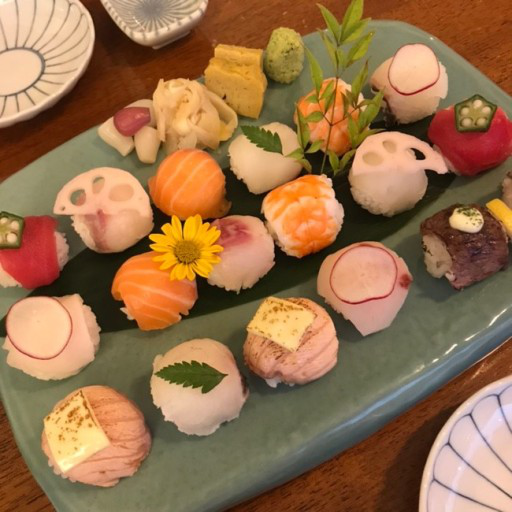

In [15]:
print(str(predict_captions(sample)))
s = predict_captions(sample)
alphabets = {'a': 0,'b': 0,'c': 0,'d': 0,'e': 0,'f': 0,'g': 0,'h': 0,'i': 0,'j': 0,'k': 0,
             'l': 0, 'm': 0,'n': 0,'o': 0, 'p': 0, 'q': 0, 'r': 0, 's': 0, 't': 0, 'u': 0,
             'v': 0, 'w': 0, 'x': 0, 'y': 0, 'z': 0}

for ch in s:
    if 97 <= ord(ch) <= 122:
        alphabets[ch] += 1
code = sorted(alphabets.items(), key=operator.itemgetter(1),reverse=True)

code_num=[]
for i in code[0][0]:
    if("a" == i or "m" == i or "y" == i):
        code_num.append(['c5', 16])
    elif("b" == i or "n" == i):
        code_num.append(['c#5', 16])
    elif("c" == i or "o" == i or "z" == i):
        code_num.append(['d5', 16])
    elif("d" == i or "p" == i):
        code_num.append(['d#5', 16])
    elif("e" == i or "q" == i):
        code_num.append(["e5", 16])
    elif("f" == i or "r" == i):
        code_num.append(["f5", 16])
    elif("g" == i or "s" == i):
        code_num.append(["f#5", 16])
    elif("h" == i or "t" == i):
        code_num.append(["g5", 16])
    elif("i" == i or "u" == i):
        code_num.append(["g#5", 16])
    elif("j" == i or "v" == i):
        code_num.append(["a5", 16])
    elif("k" == i or "w" == i):
        code_num.append(["a#5", 16])
    elif("l" == i or "x" == i):
        code_num.append(["b5", 16])
        
code_num = list(itertools.chain.from_iterable(code_num))   
song[0][0] = code_num

matrix = MusicMatrix(random.choice(song))   

num = 0
for i in song:
    song[num][0] = song[0][0]
    num += 1

start_note = song[0][0]

random_song = []
for i in range(0, 100):
    start_note = matrix.next_note(start_note)
    random_song.append(start_note)

make_midi(midi_path='midi/random_music.mid', notes=random_song)   
print(random_song)
Image.open(sample)